<a href="https://colab.research.google.com/github/louiezzang/nextmining-forecasting/blob/main/notebooks/temporal_fusion_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/louiezzang/nextmining-forecasting.git

  Cloning https://github.com/louiezzang/nextmining-forecasting.git to /tmp/pip-req-build-q3iqoyj6
  Running command git clone --filter=blob:none --quiet https://github.com/louiezzang/nextmining-forecasting.git /tmp/pip-req-build-q3iqoyj6
  Resolved https://github.com/louiezzang/nextmining-forecasting.git to commit 24a971079721b445f19ea45fda15daf94423b244
  Preparing metadata (setup.py) ... done
  Created wheel for nextmining-forecasting: filename=nextmining_forecasting-0.0.1-py3-none-any.whl size=15124 sha256=630b42d53136699470049b14ffd644671ddffd9acbf96bd8a0509ea2743ebf51
  Stored in directory: /tmp/pip-ephem-wheel-cache-h4nkoc9f/wheels/0f/d3/1d/810cd98849b418ad576b15e349496444724c81dc944d8e9c78
Successfully built nextmining-forecasting


In [2]:
import time
import gc
import glob
import os
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch import nn
import torchvision
import torch

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from forecasting.data import TimeSeriesDataset
from forecasting.models import TemporalFusionTransformer, QuantileLoss

In [3]:
def fit_preprocessing(train, real_columns, categorical_columns):
    real_scalers = StandardScaler().fit(train[real_columns].values)

    categorical_scalers = {}
    num_classes = []
    for col in categorical_columns:
        srs = train[col].apply(str)
        categorical_scalers[col] = LabelEncoder().fit(srs.values)
        num_classes.append(srs.nunique())

    return real_scalers, categorical_scalers


def transform_inputs(df, real_scalers, categorical_scalers, real_columns, categorical_columns):
    out = df.copy()
    out[real_columns] = real_scalers.transform(df[real_columns].values)

    for col in categorical_columns:
        string_df = df[col].apply(str)
        out[col] = categorical_scalers[col].transform(string_df)

    return out

In [4]:
class WebTrafficGenerator:
    def __init__(self, start_date="2021-01-01", end_date="2024-12-31", trend_base=0.5,
                 weekly_seasonality=None, yearly_seasonality=None, noise_multiplier=10):
        self.dates = dates = pd.date_range(start=start_date, end=end_date, freq="D")
        self.trend_base = trend_base
        self.weekly_seasonality = weekly_seasonality
        self.yearly_seasonality = yearly_seasonality
        self.noise_multiplier = noise_multiplier
        self.web_traffic = []

    def generate_data(self):

        day = 24 * 60 * 60
        week = day * 7
        year = 365.2425 * day

        if self.yearly_seasonality:
            yearly = ((1 + np.sin(self.dates.view("int64") // 1e9 * \
                                  (self.yearly_seasonality * np.pi / year))) * 100).astype(int)
        else:
            yearly = 0

        if self.weekly_seasonality:
            weekly = ((1 + np.sin(self.dates.view("int64") // 1e9 * \
                                  (self.weekly_seasonality * np.pi / week))) * 10).astype(int)
        else:
            weekly = 0

        trend = np.array(range(len(self.dates)))*self.trend_base
        noise = ((np.random.random(len(self.dates))-0.5)*self.noise_multiplier).astype(int)

        return trend+yearly+weekly+noise


(array([18628., 18809., 18993., 19174., 19358., 19539., 19723., 19905.,
        20089.]),
 [Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01'),
  Text(19539.0, 0, '2023-07'),
  Text(19723.0, 0, '2024-01'),
  Text(19905.0, 0, '2024-07'),
  Text(20089.0, 0, '2025-01')])

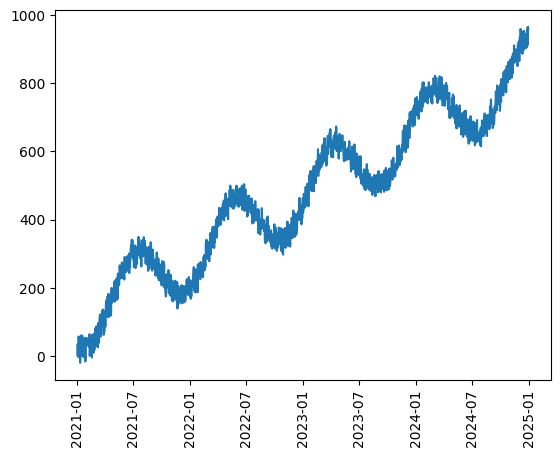

In [5]:
traffic_generator = WebTrafficGenerator(start_date="2021-01-01",
                                        end_date="2024-12-31",
                                        trend_base=0.5,
                                        weekly_seasonality=0.7,
                                        yearly_seasonality=2.3,
                                        noise_multiplier=80)
traffic = traffic_generator.generate_data()

plt.plot(traffic_generator.dates, traffic)
plt.xticks(rotation=90)

In [6]:
entities = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P"]
groups = {"High": ["A", "B", "C", "D", "E"], "Medium": ["F", "G", "H", "I", "J", "K"], "Low": ["L", "M", "N", "O", "P"]}

In [7]:
raw = pd.DataFrame(columns=["date", "traffic", "Entity", "Class", "DayOfWeek", "DayOfMonth", "WeekOfYear", "Month", "Year"])

for e in entities:
    trend_base = np.round(np.random.random(), 2)

    if e in groups["High"]:
        trend_base *= 1.5
        group = "High"
    elif e in groups["Low"]:
        trend_base *= 0.7
        group = "Low"
    else:
        group = "Medium"

    traffic_generator = WebTrafficGenerator(start_date="2020-01-01",
                                            end_date="2024-12-31",
                                            trend_base=trend_base,
                                            weekly_seasonality=0.7 +np.round(np.random.uniform(0, 2.0), 2),
                                            yearly_seasonality=6.0 +np.round(np.random.uniform(0, 2.0), 2),
                                            noise_multiplier=80)

    traffic = traffic_generator.generate_data()
    tmp = pd.DataFrame(data={"date": traffic_generator.dates, "traffic":traffic})
    tmp["Entity"] = [e]*tmp.shape[0]
    tmp["Class"] = [group]*tmp.shape[0]
    tmp["DayOfWeek"] = tmp.date.dt.dayofweek
    tmp["DayOfMonth"] = tmp.date.dt.day
    tmp["WeekOfYear"] = tmp.date.dt.isocalendar().week
    tmp["Month"] = tmp.date.dt.month
    tmp["Year"] = tmp.date.dt.year
    tmp["DaysFromStart"] = np.arange(tmp.shape[0])
    tmp["Delta"] = tmp["traffic"].diff().fillna(0)

    raw = pd.concat([raw, tmp])

raw.reset_index(inplace=True)

In [19]:
raw

index       date  traffic Entity Class DayOfWeek DayOfMonth  \
0          0 2020-01-01   72.000      A  High         2          1   
1          1 2020-01-02   61.705      A  High         3          2   
2          2 2020-01-03   73.410      A  High         4          3   
3          3 2020-01-04  116.115      A  High         5          4   
4          4 2020-01-05  124.820      A  High         6          5   
...      ...        ...      ...    ...   ...       ...        ...   
29227   1822 2024-12-27  872.454      P   Low         4         27   
29228   1823 2024-12-28  884.811      P   Low         5         28   
29229   1824 2024-12-29  865.168      P   Low         6         29   
29230   1825 2024-12-30  866.525      P   Low         0         30   
29231   1826 2024-12-31  827.882      P   Low         1         31   

       WeekOfYear Month  Year  DaysFromStart   Delta  
0               1     1  2020            0.0   0.000  
1               1     1  2020            1.0 -10.295  
2               1     1  2020            2.0  11.705  
3               1     1  2020            3.0  42.705  
4               1     1  2020            4.0   8.705  
...           ...   ...   ...            ...     ...  
29227          52    12  2024         1822.0  36.357  
29228          52    12  2024         1823.0  12.357  
29229          52    12  2024         1824.0 -19.643  
29230           1    12  2024         1825.0   1.357  
29231           1    12  2024         1826.0 -38.643  

[29232 rows x 12 columns]

(array([17897., 18262., 18628., 18993., 19358., 19723., 20089.]),
 [Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

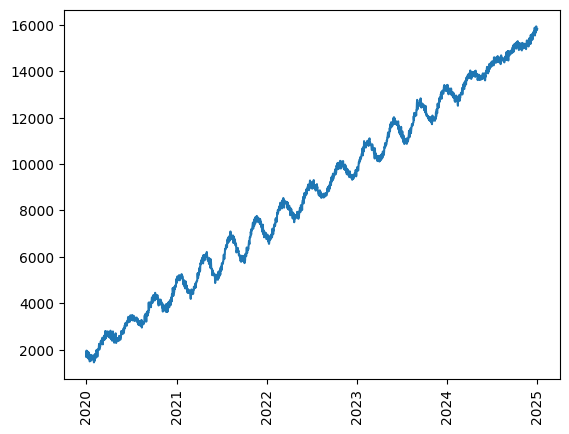

In [8]:
total = raw.groupby("date")["traffic"].sum()
plt.plot(total.index, total)
plt.xticks(rotation=90)

In [9]:
train = raw[raw["date"] < "2023-01-01"]
valid = raw.loc[(raw["date"] >= "2023-01-01") & (raw["date"] < "2024-01-01")]
test = raw.loc[(raw["date"] > "2024-01-01")]

In [10]:
real_columns = ["traffic", "Delta", "DaysFromStart"]
categorical_columns = ["Entity", "DayOfWeek", "DayOfMonth", "WeekOfYear", "Month", "Class"]

real_scalers, categorical_scalers = fit_preprocessing(train, real_columns, categorical_columns)

train = transform_inputs(train, real_scalers, categorical_scalers, real_columns, categorical_columns)
# valid = transform_inputs(valid, real_scalers, categorical_scalers, real_columns, categorical_columns)
test = transform_inputs(test, real_scalers, categorical_scalers, real_columns, categorical_columns)

In [11]:
# Global variables

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_EPOCHS = 2
DROPOUT = 0.3
LEARNING_RATE = 0.001
ENCODER_STEPS = 175
DECODER_STEPS = ENCODER_STEPS + 5
HIDDEN_LAYER_SIZE = 80
EMBEDDING_DIMENSION = 8
NUM_LSTM_LAYERS = 1
NUM_ATTENTION_HEADS = 2
QUANTILES = [0.1, 0.5, 0.9]


# Dataset variables
input_columns = ["traffic", "Delta", "DaysFromStart", "DayOfWeek", "DayOfMonth", "WeekOfYear", "Month", "Entity", "Class", "Entity"]
target_column = "traffic"
entity_column = "Entity"
time_column = "date"
col_to_idx = {col: idx for idx, col in enumerate(input_columns)}

In [12]:
params = {
    "quantiles": QUANTILES,
    "batch_size": BATCH_SIZE,
    "dropout": DROPOUT,
    "device": DEVICE,
    "hidden_layer_size": HIDDEN_LAYER_SIZE,
    "num_lstm_layers": NUM_LSTM_LAYERS,
    "embedding_dim": EMBEDDING_DIMENSION,
    "encoder_steps": ENCODER_STEPS,
    "num_attention_heads": NUM_ATTENTION_HEADS,
    "col_to_idx": col_to_idx,
    "static_covariates": ["Class", "Entity"],
    "time_dependent_categorical": ["DayOfWeek", "DayOfMonth", "WeekOfYear", "Month"],
    "time_dependent_continuous": ["traffic", "DaysFromStart", "Delta"],
    "category_counts": {"DayOfWeek": 7, "DayOfMonth": 31, "WeekOfYear": 53, "Month": 12, "Class": 3, "Entity": 16},
    "known_time_dependent": ["DayOfWeek", "DayOfMonth", "WeekOfYear", "Month", "DaysFromStart"],
    "observed_time_dependent": ["traffic", "Delta"]
}

In [13]:
training_data = TimeSeriesDataset(train, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)
#validation_data = TimeSeriesDataset(valid, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)
testing_data = TimeSeriesDataset(test, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)
# valid_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)

In [14]:
model = TemporalFusionTransformer(params)
model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


TemporalFusionTransformer(
  (static_embeddings): ModuleDict(
    (Class): Embedding(3, 8)
    (Entity): Embedding(16, 8)
  )
  (static_variable_selection): VariableSelectionNetwork(
    (flattened_inputs): GatedResidualNetwork(
      (skip_layer): Linear(in_features=16, out_features=2, bias=True)
      (dense1): Linear(in_features=16, out_features=80, bias=True)
      (elu): ELU(alpha=1.0)
      (dense2): Linear(in_features=80, out_features=2, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (gate): GLU(
        (a): Linear(in_features=2, out_features=2, bias=True)
        (sigmoid): Sigmoid()
        (b): Linear(in_features=2, out_features=2, bias=True)
      )
      (layer_norm): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (transformed_inputs): ModuleList(
      (0-1): 2 x GatedResidualNetwork(
        (skip_layer): Linear(in_features=8, out_features=80, bias=True)
        (dense1): Linear(in_features=8, out_features=80, bi

In [15]:
criterion = QuantileLoss(QUANTILES)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print_every_k = 100
losses = []

for epoch in range(NUM_EPOCHS):
    t0 = time.time()
    print(f"===== Epoch {epoch+1} =====")
    epoch_loss = 0.0
    running_loss = 0.0

    for i, batch in enumerate(train_dataloader):
        labels = batch["outputs"][:,:,0].flatten().float().to(DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs, attention_weights = model(batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        epoch_loss += loss.item()

        if (i+1) % print_every_k == 0:
            print(f"Mini-batch {i+1} average loss: {round(running_loss / print_every_k, 5)}")
            running_loss = 0.0

    t1 = time.time()
    print(f"\nEpoch trained for {round(t1-t0, 2)} seconds")
    print("\nEpoch loss:", round(epoch_loss / (i+1), 5), "\n")
    losses.append(epoch_loss / (i+1))

===== Epoch 1 =========


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Mini-batch 100 average loss: 0.93483
Mini-batch 200 average loss: 0.52742
Mini-batch 300 average loss: 0.94472
Mini-batch 400 average loss: 0.59599


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Epoch trained for 47.96 seconds

Epoch loss: 0.72961 

===== Epoch 2 =========
Mini-batch 100 average loss: 0.60196
Mini-batch 200 average loss: 0.43158
Mini-batch 300 average loss: 0.48465
Mini-batch 400 average loss: 0.45881

Epoch trained for 35.6 seconds

Epoch loss: 0.47962 



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Plotting interpreation plots for a batch of entity 0:


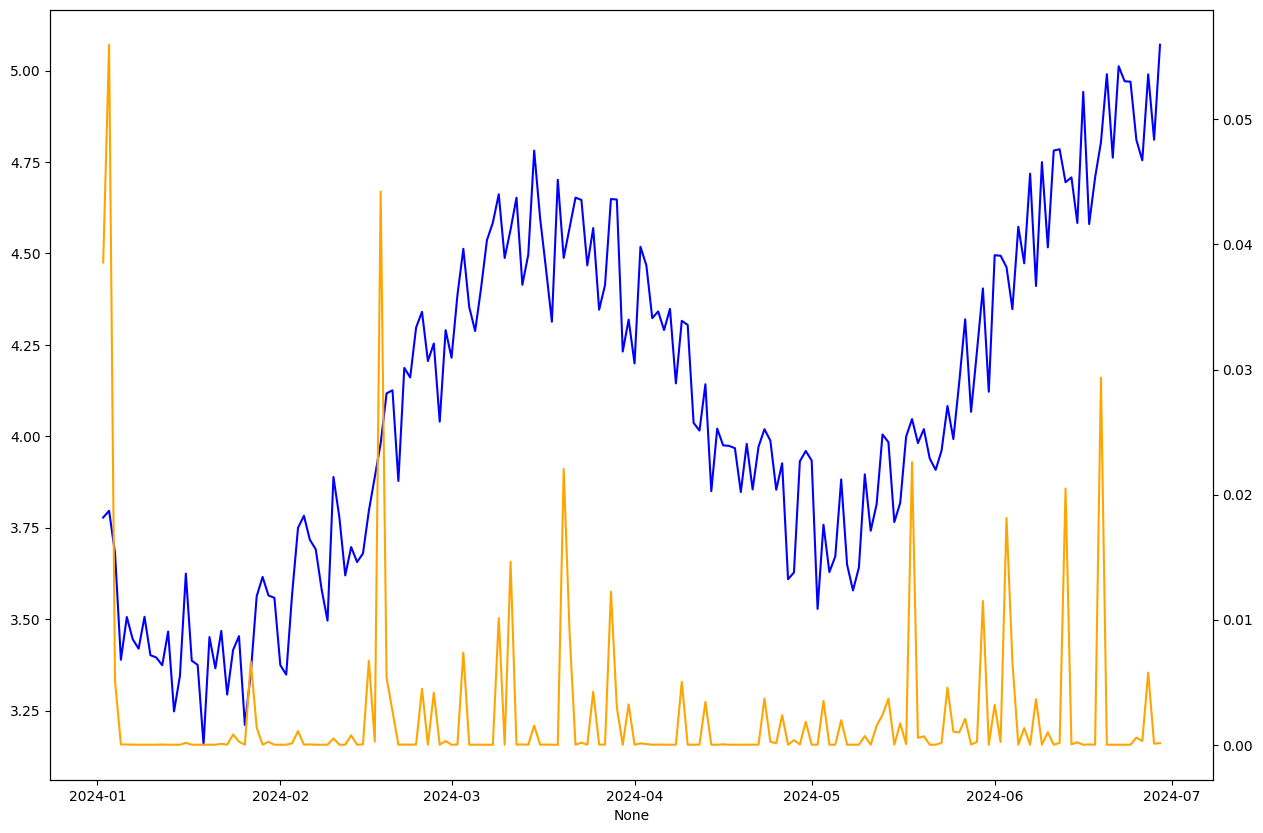

<ipython-input-16-22990e02c288>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


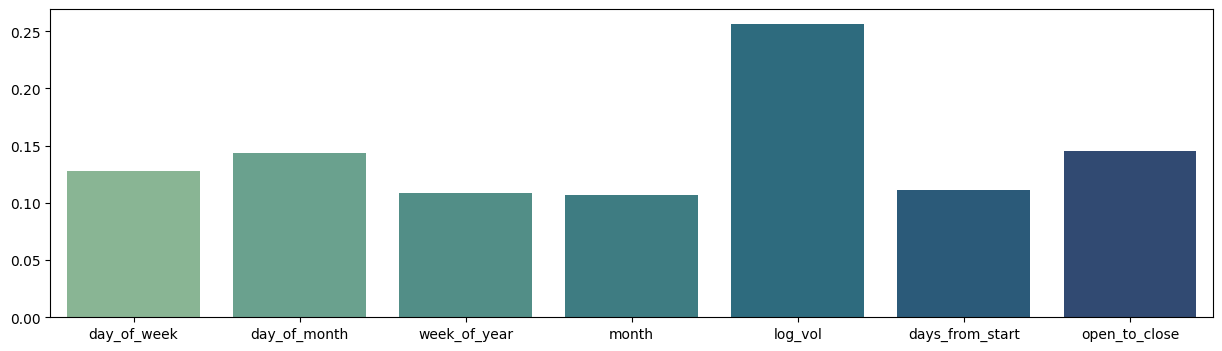

<ipython-input-16-22990e02c288>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


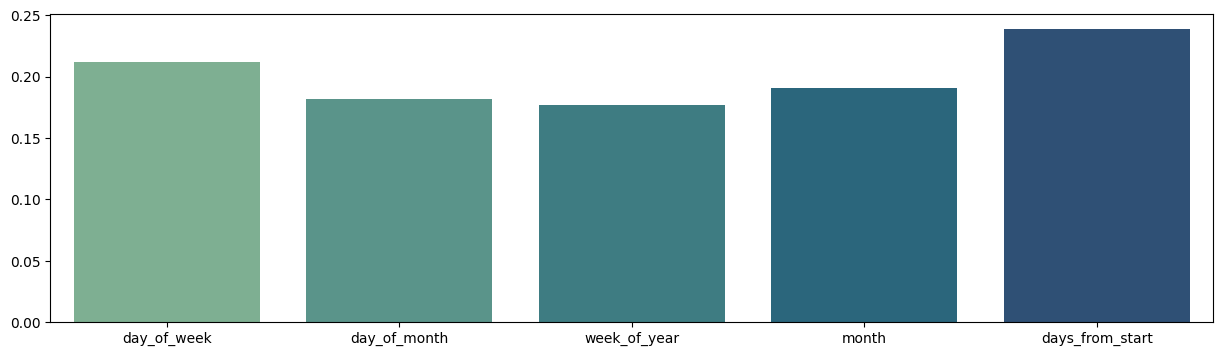


Plotting interpreation plots for a batch of entity 1:


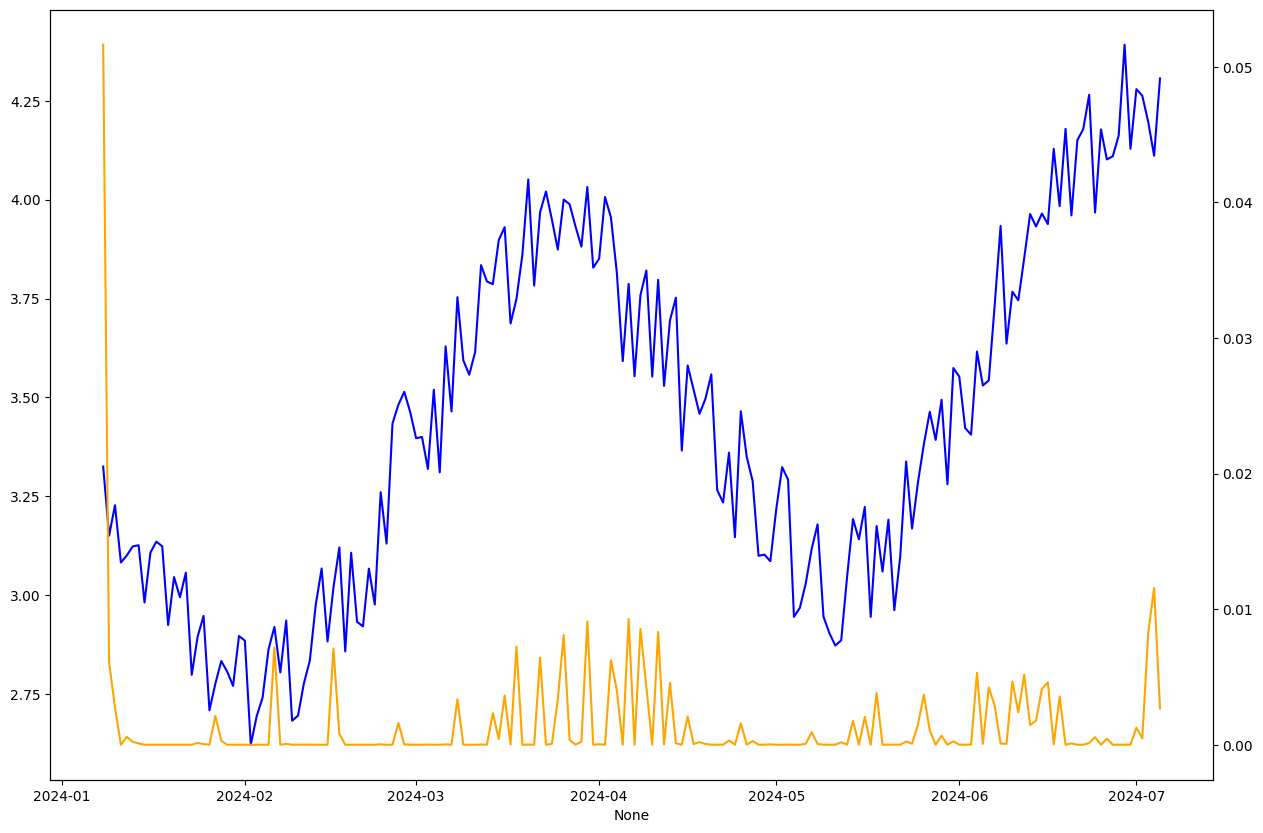

<ipython-input-16-22990e02c288>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


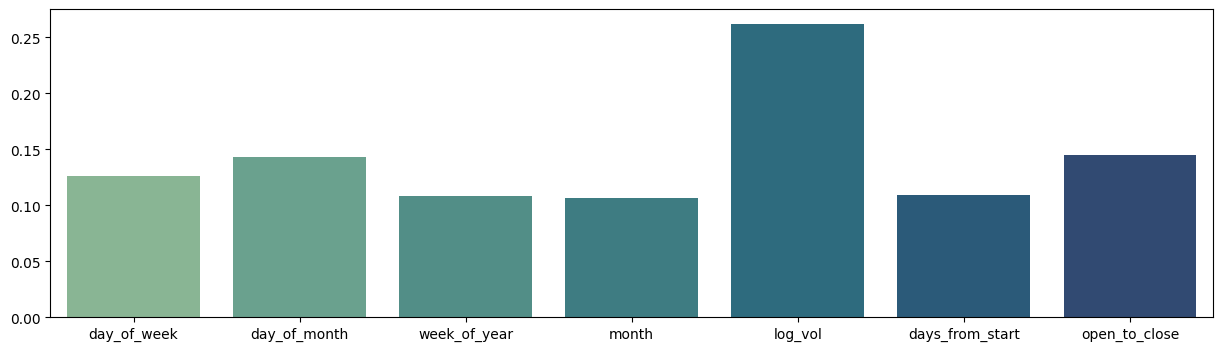

<ipython-input-16-22990e02c288>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


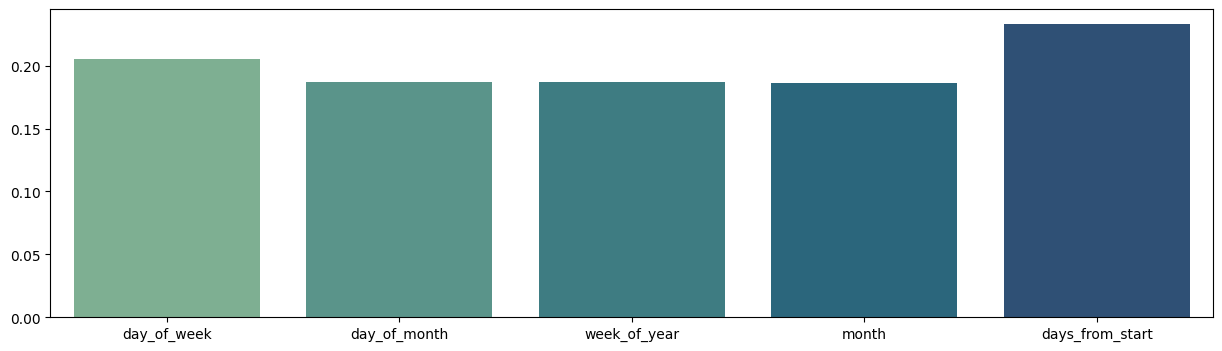


Plotting interpreation plots for a batch of entity 2:


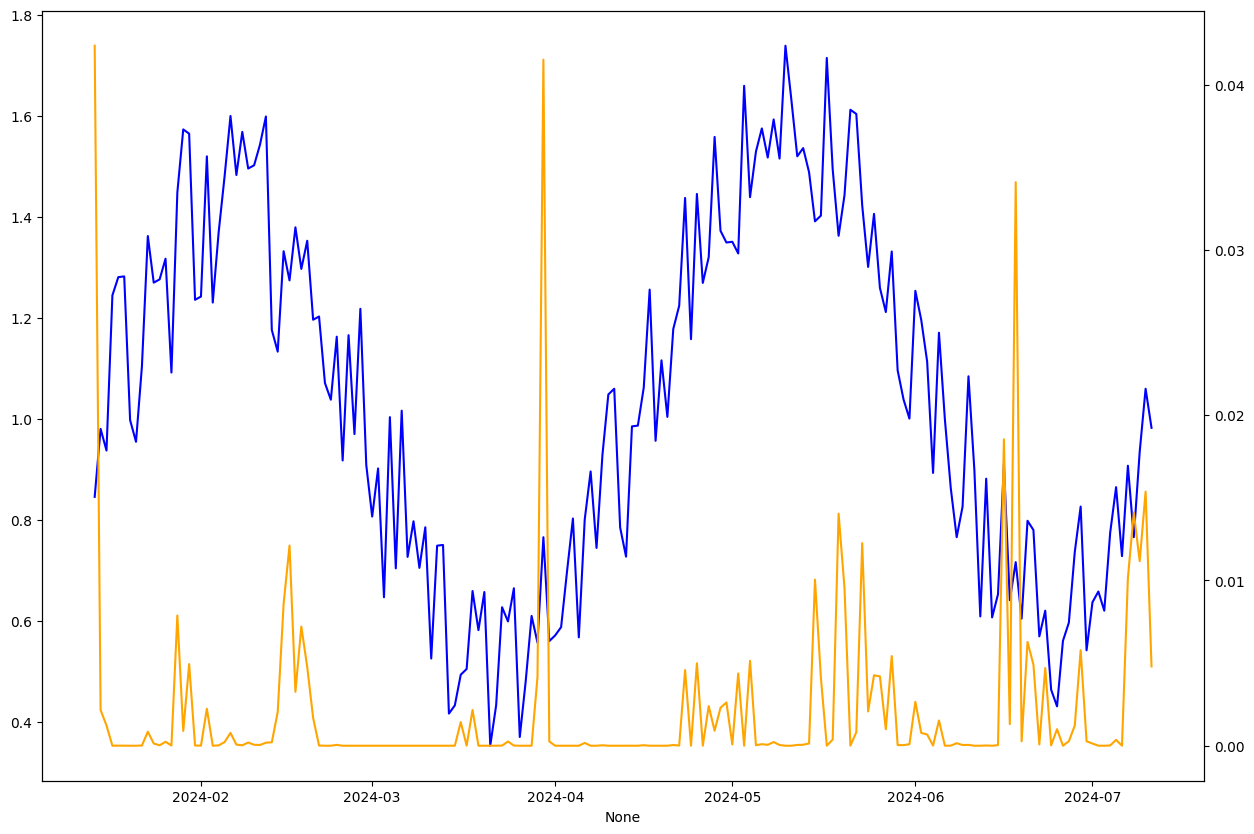

<ipython-input-16-22990e02c288>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


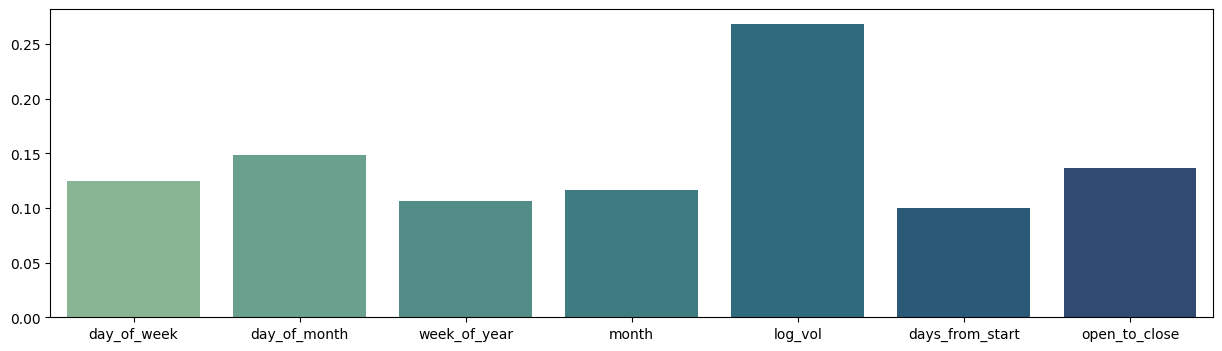

<ipython-input-16-22990e02c288>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


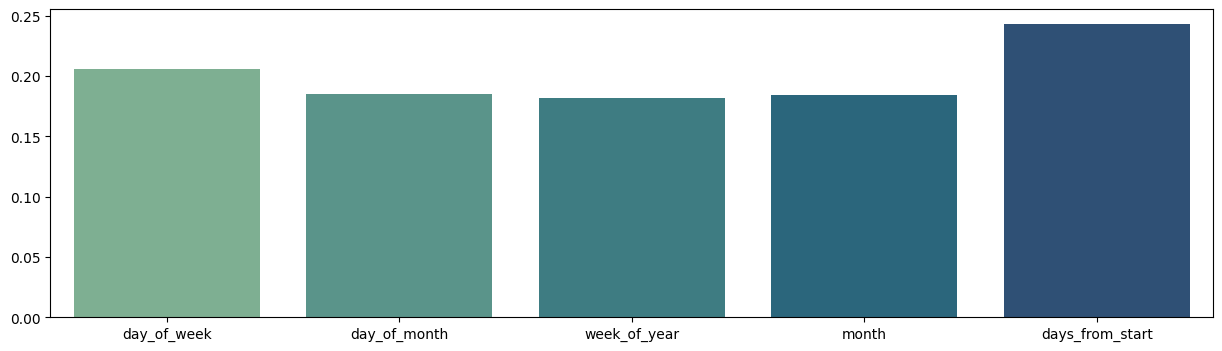


Plotting interpreation plots for a batch of entity 3:


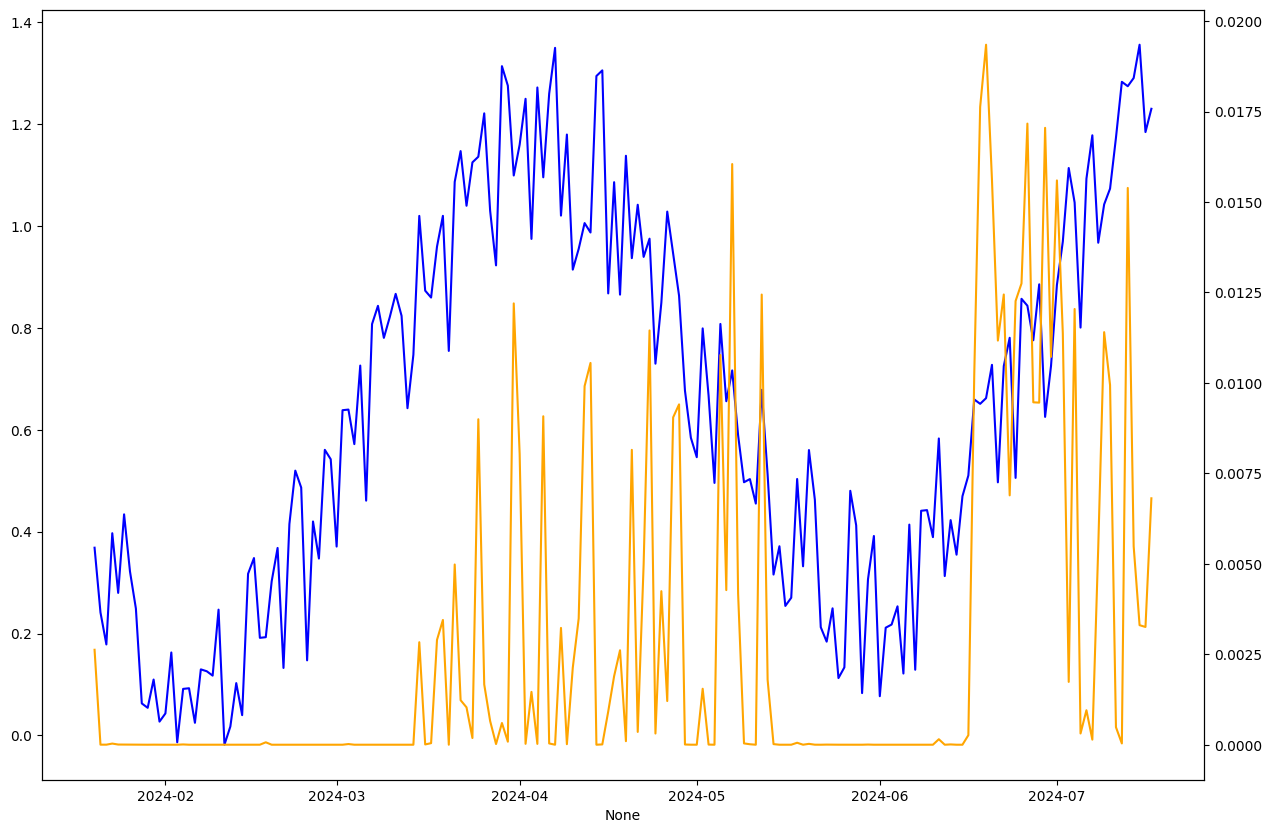

<ipython-input-16-22990e02c288>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


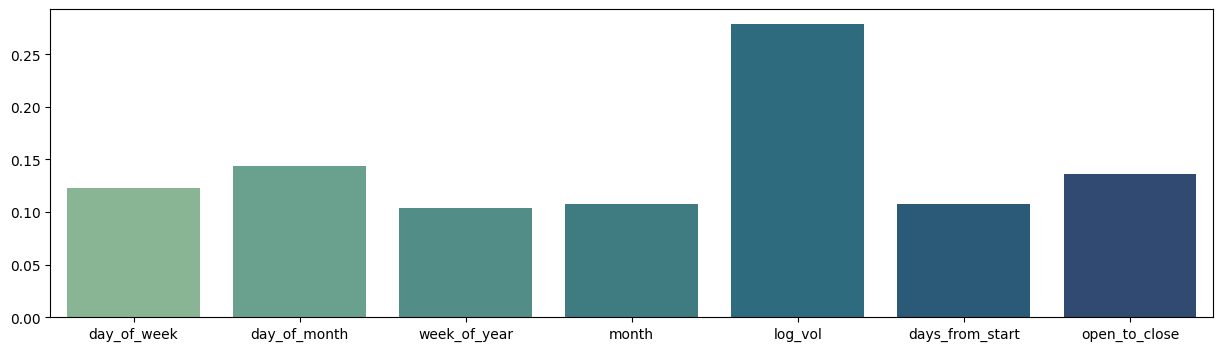

<ipython-input-16-22990e02c288>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


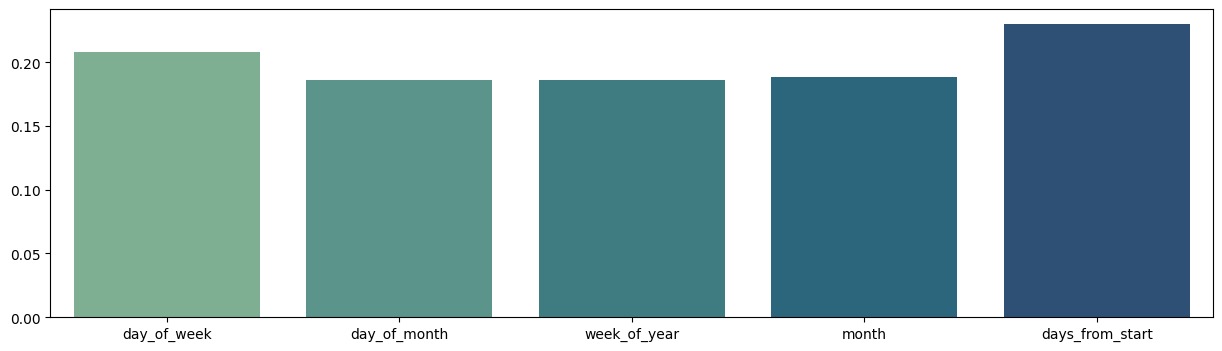


Plotting interpreation plots for a batch of entity 4:


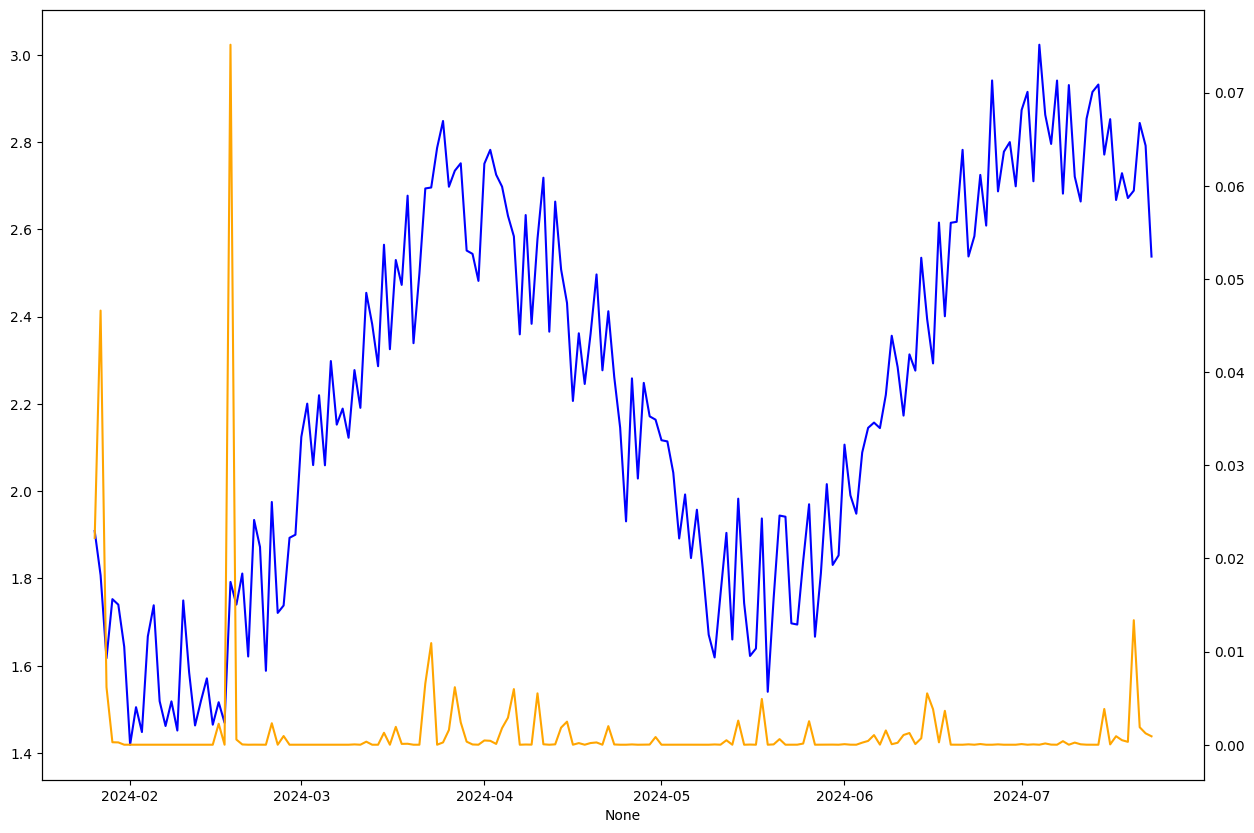

<ipython-input-16-22990e02c288>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


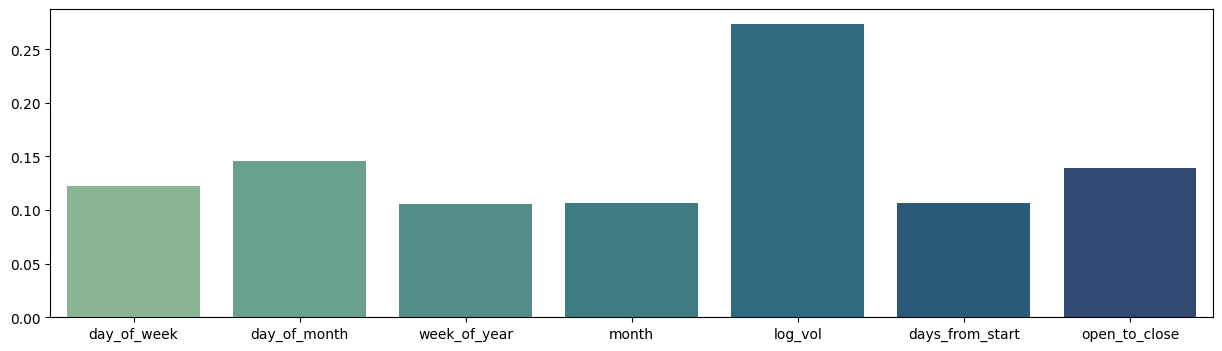

<ipython-input-16-22990e02c288>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


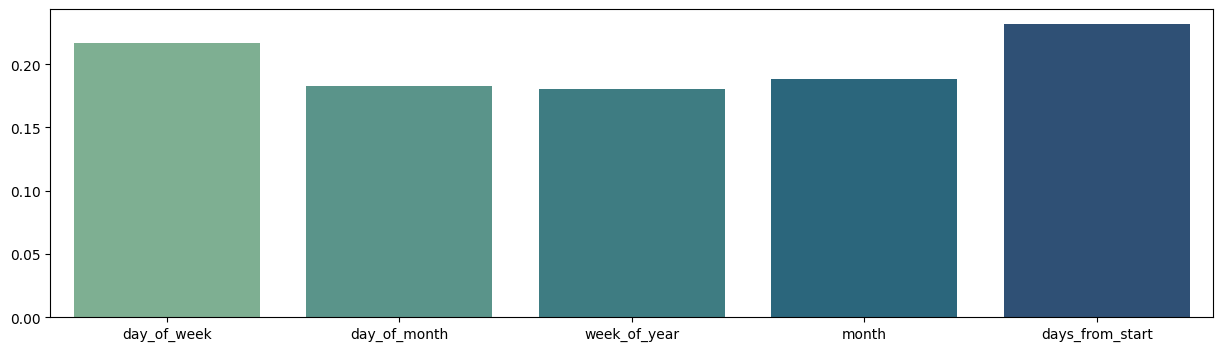


Plotting interpreation plots for a batch of entity 5:


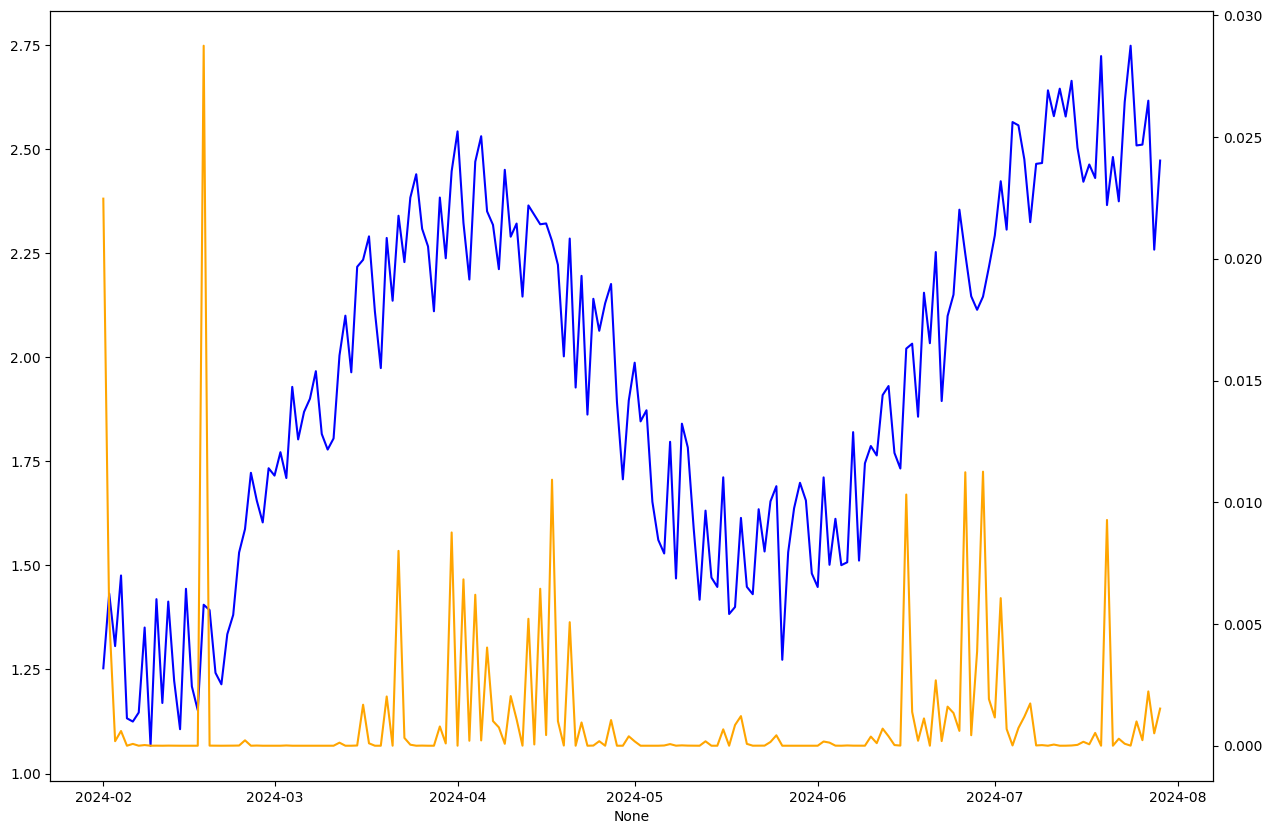

<ipython-input-16-22990e02c288>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


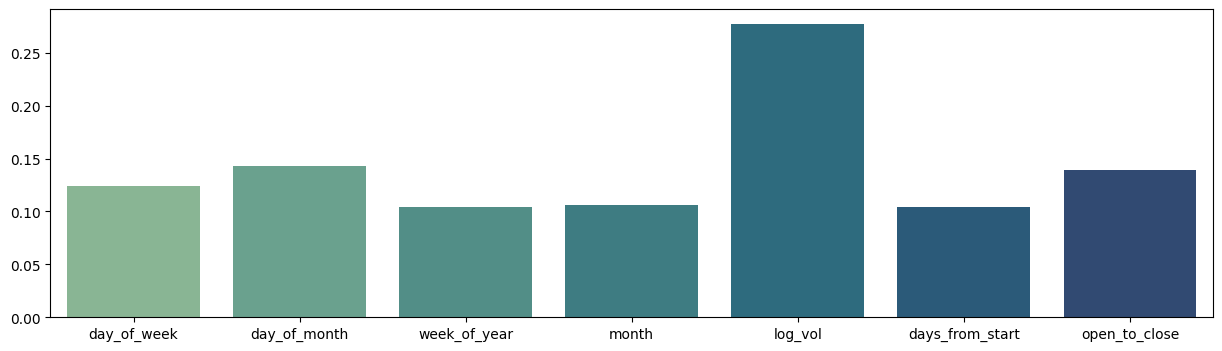

<ipython-input-16-22990e02c288>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


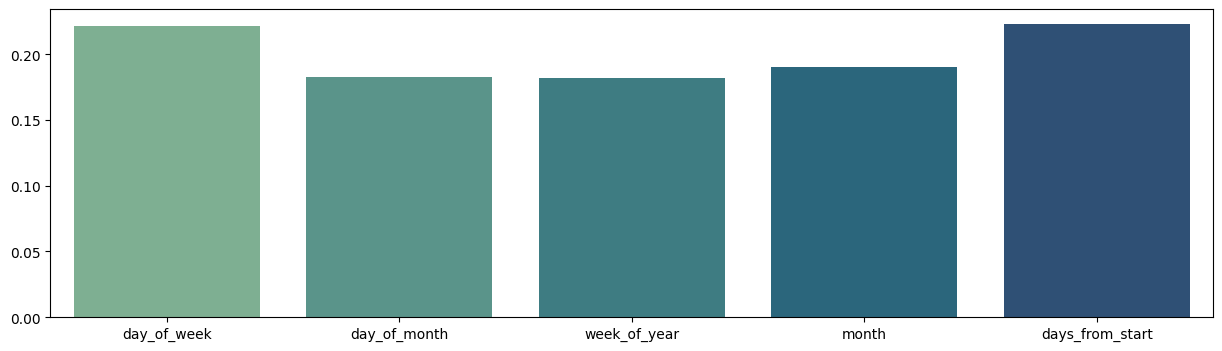


Plotting interpreation plots for a batch of entity 6:


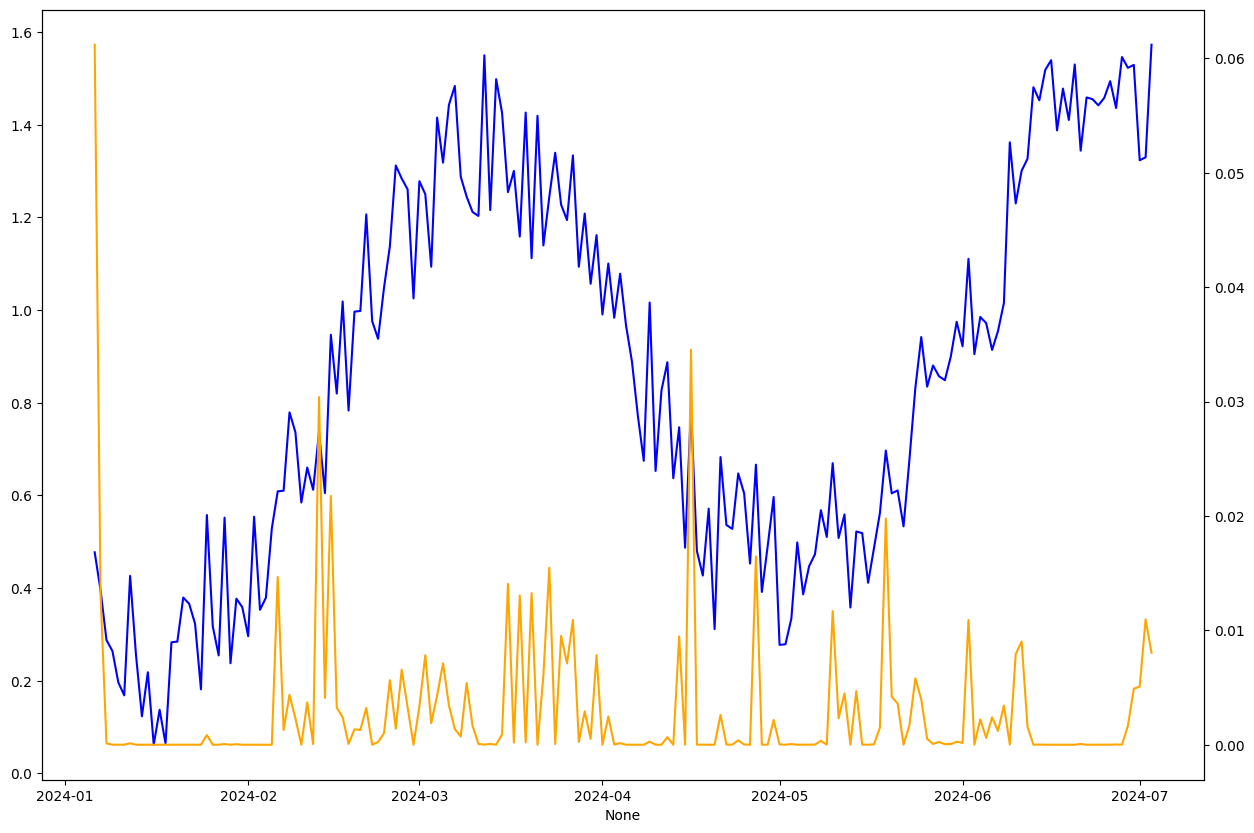

<ipython-input-16-22990e02c288>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


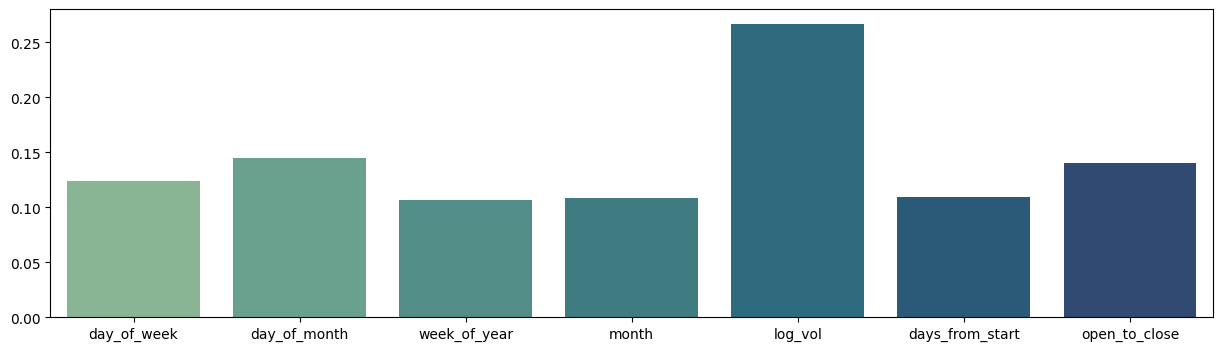

<ipython-input-16-22990e02c288>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


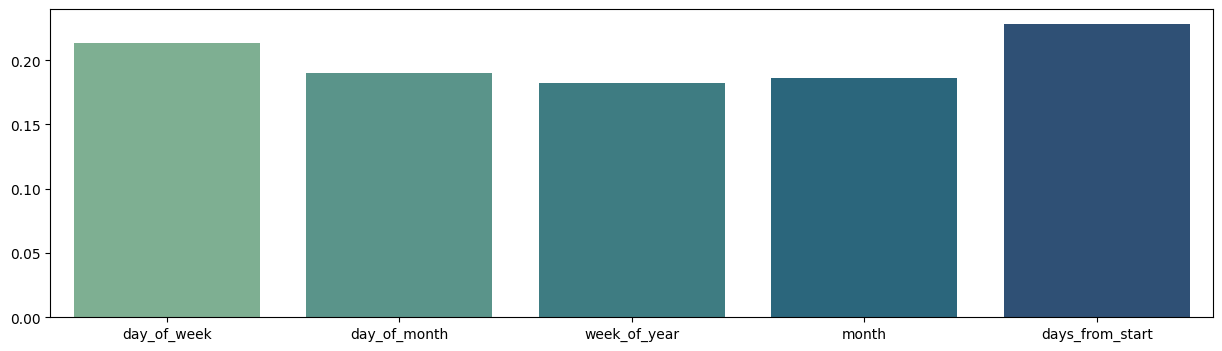


Plotting interpreation plots for a batch of entity 7:


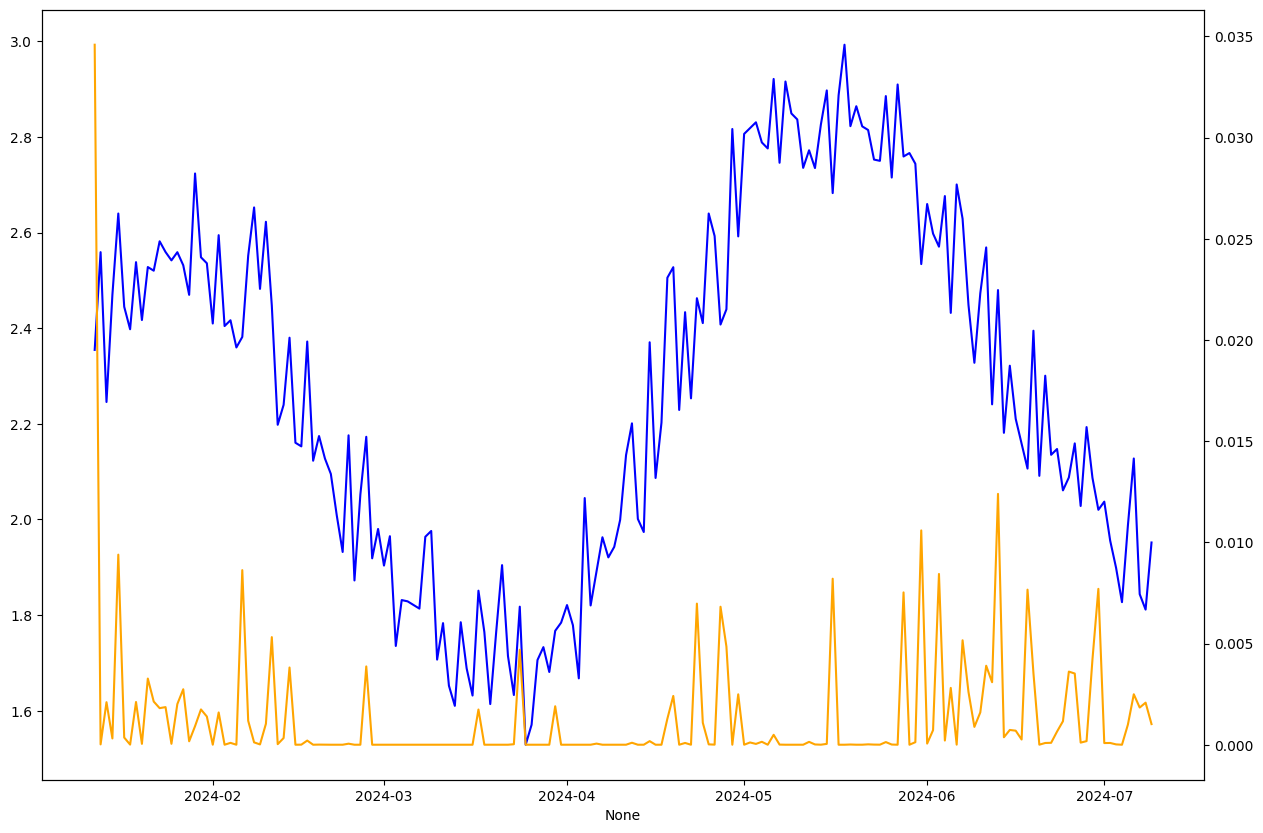

<ipython-input-16-22990e02c288>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


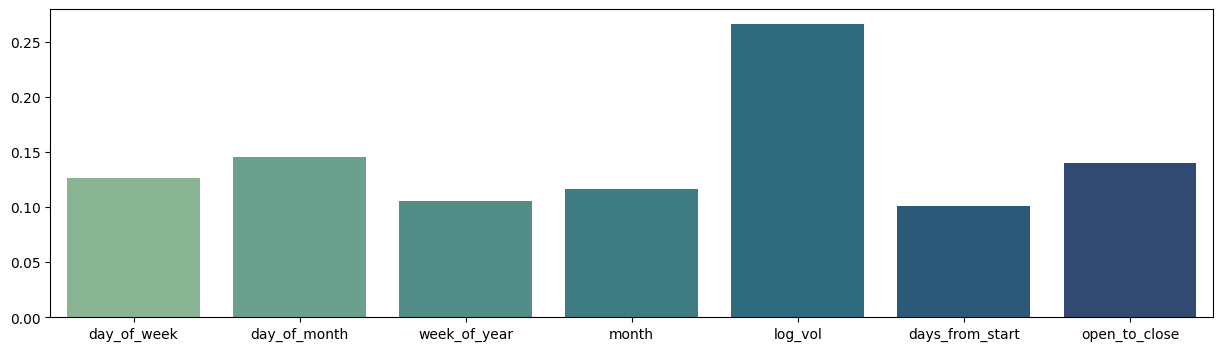

<ipython-input-16-22990e02c288>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


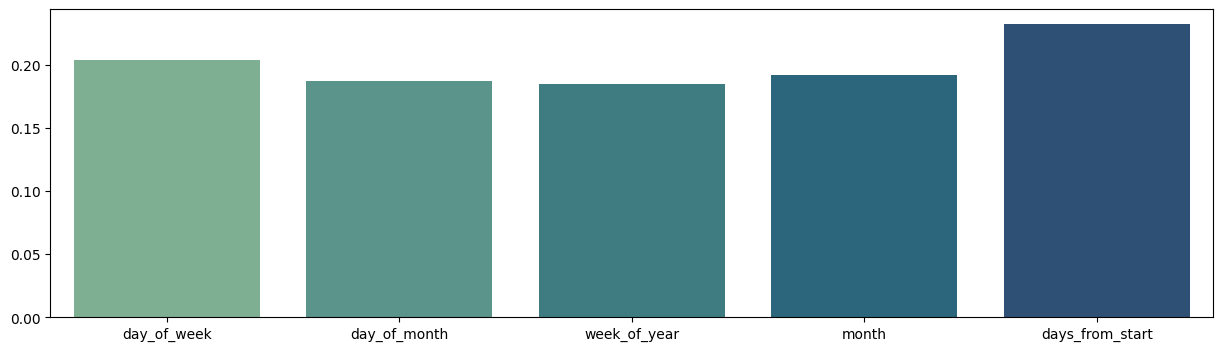


Plotting interpreation plots for a batch of entity 8:


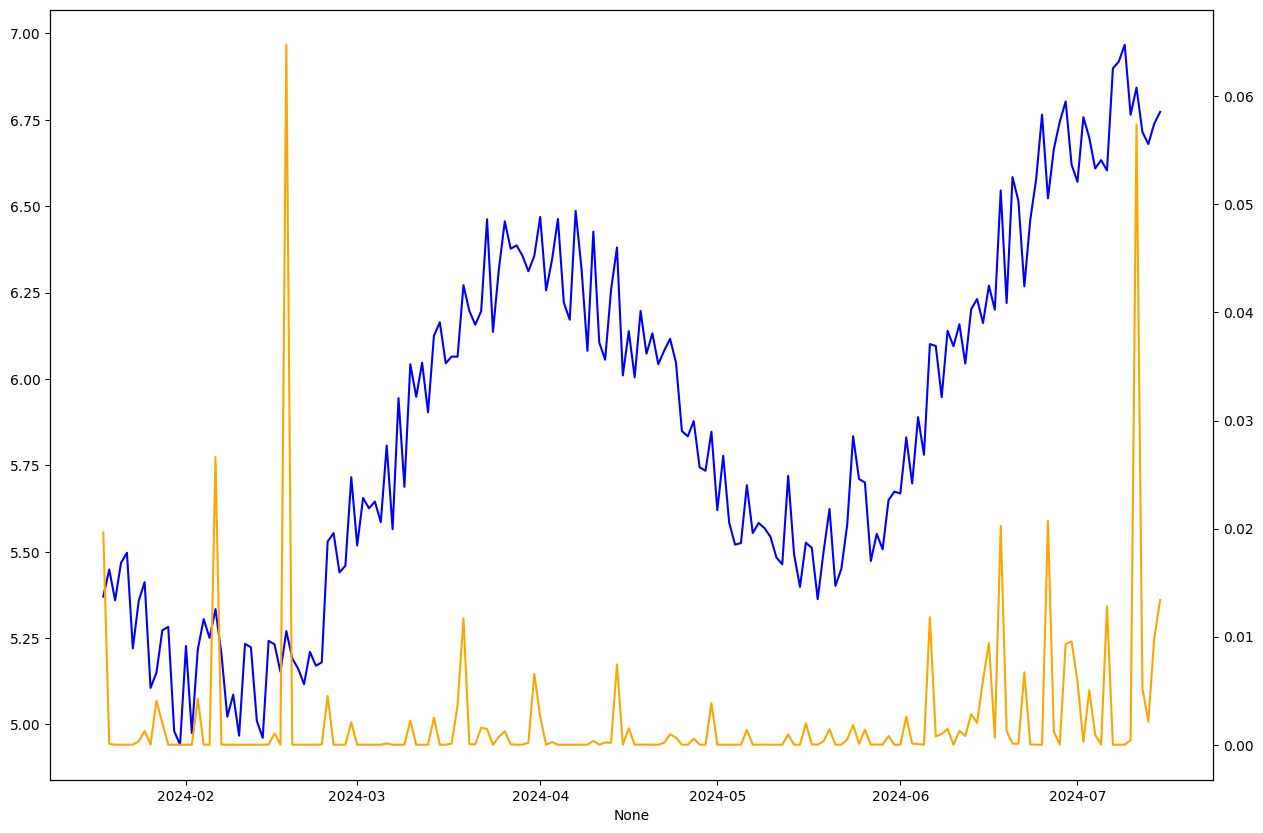

<ipython-input-16-22990e02c288>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


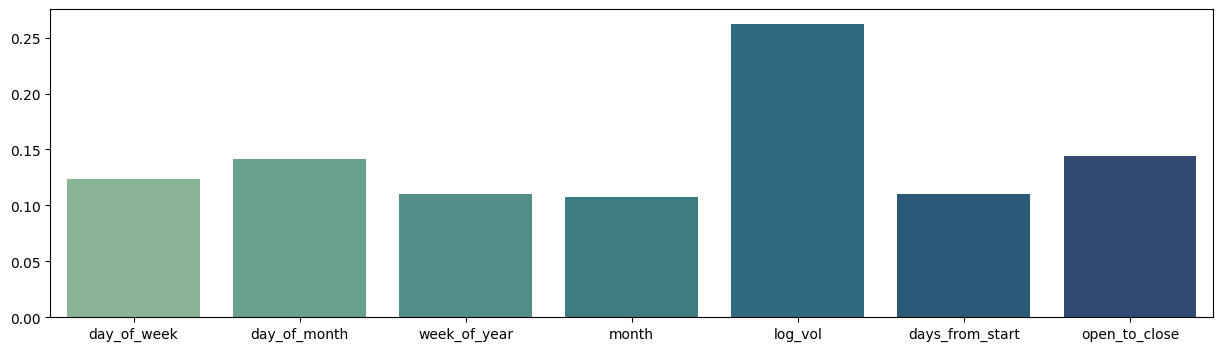

<ipython-input-16-22990e02c288>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


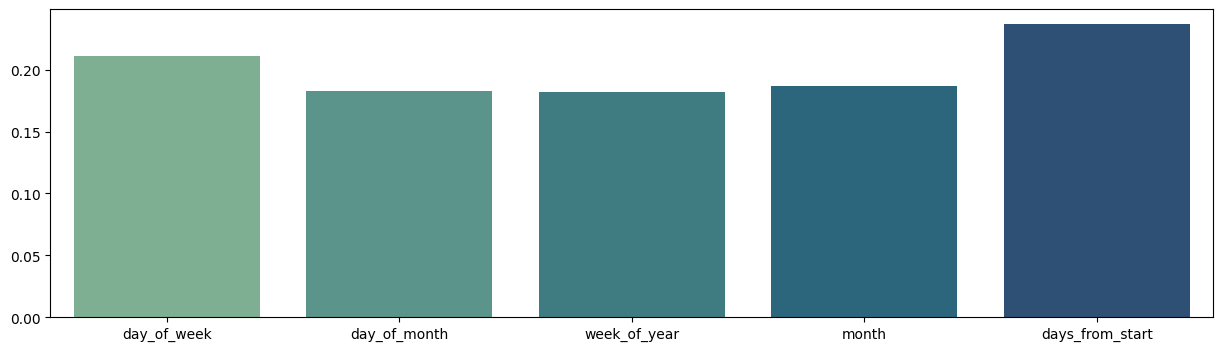


Plotting interpreation plots for a batch of entity 9:


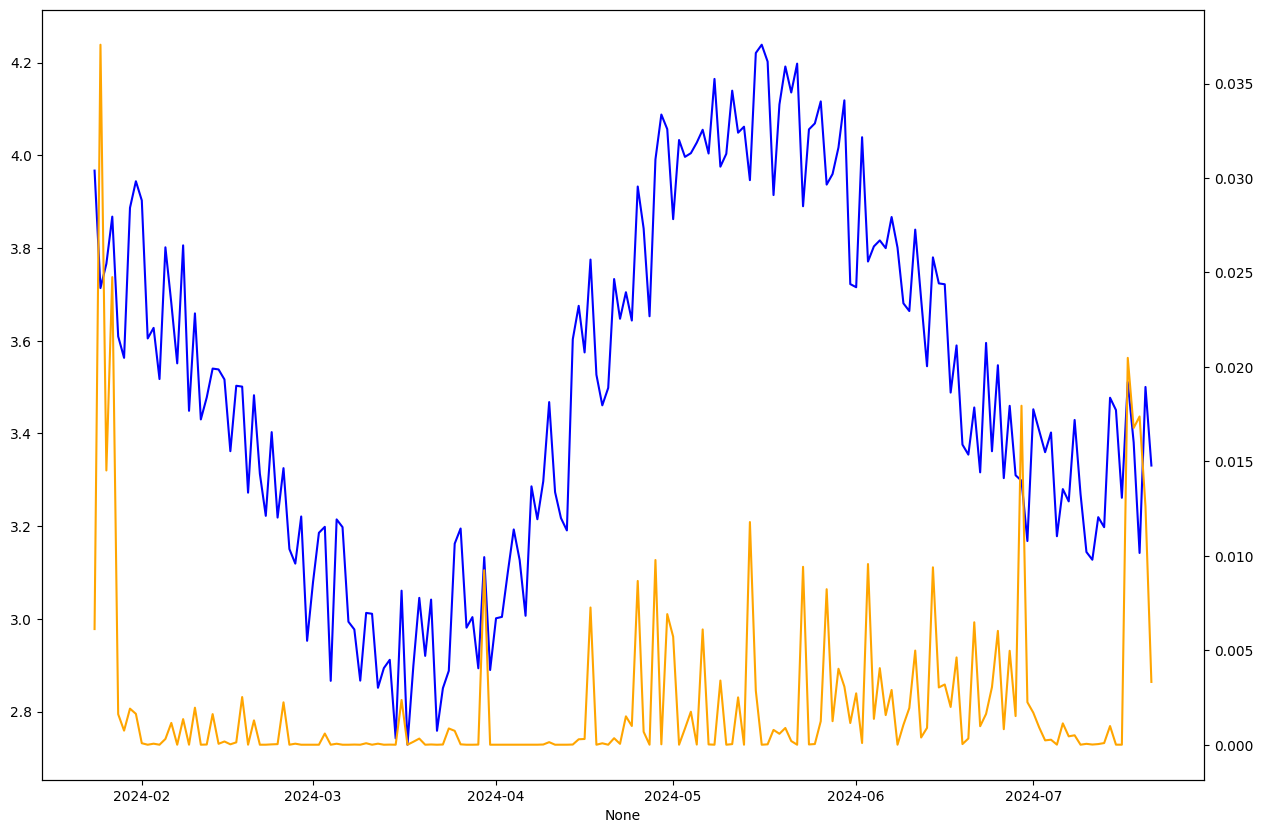

<ipython-input-16-22990e02c288>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


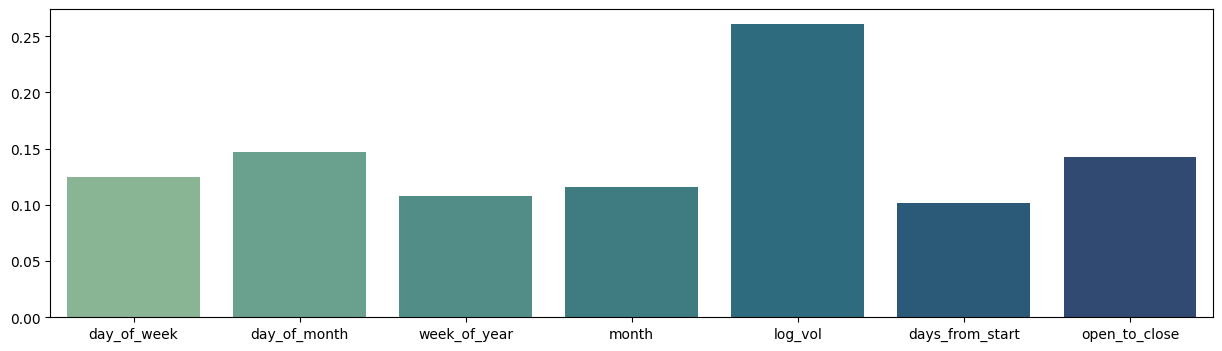

<ipython-input-16-22990e02c288>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


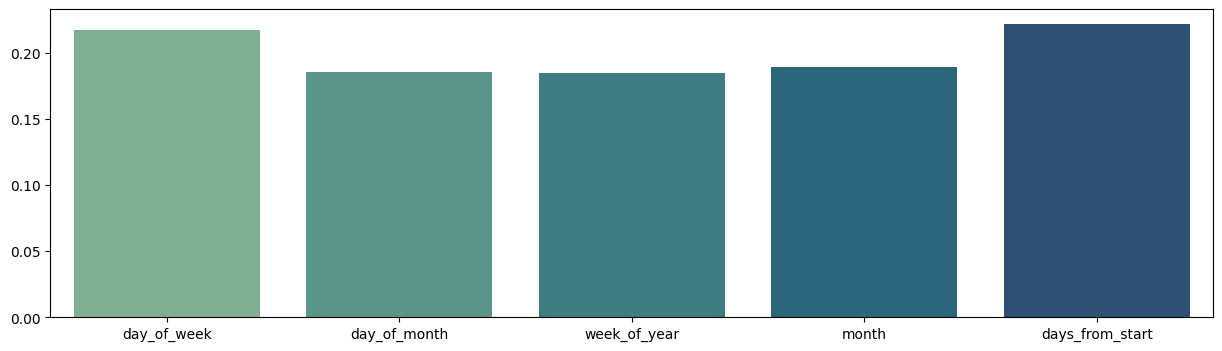


Plotting interpreation plots for a batch of entity 10:


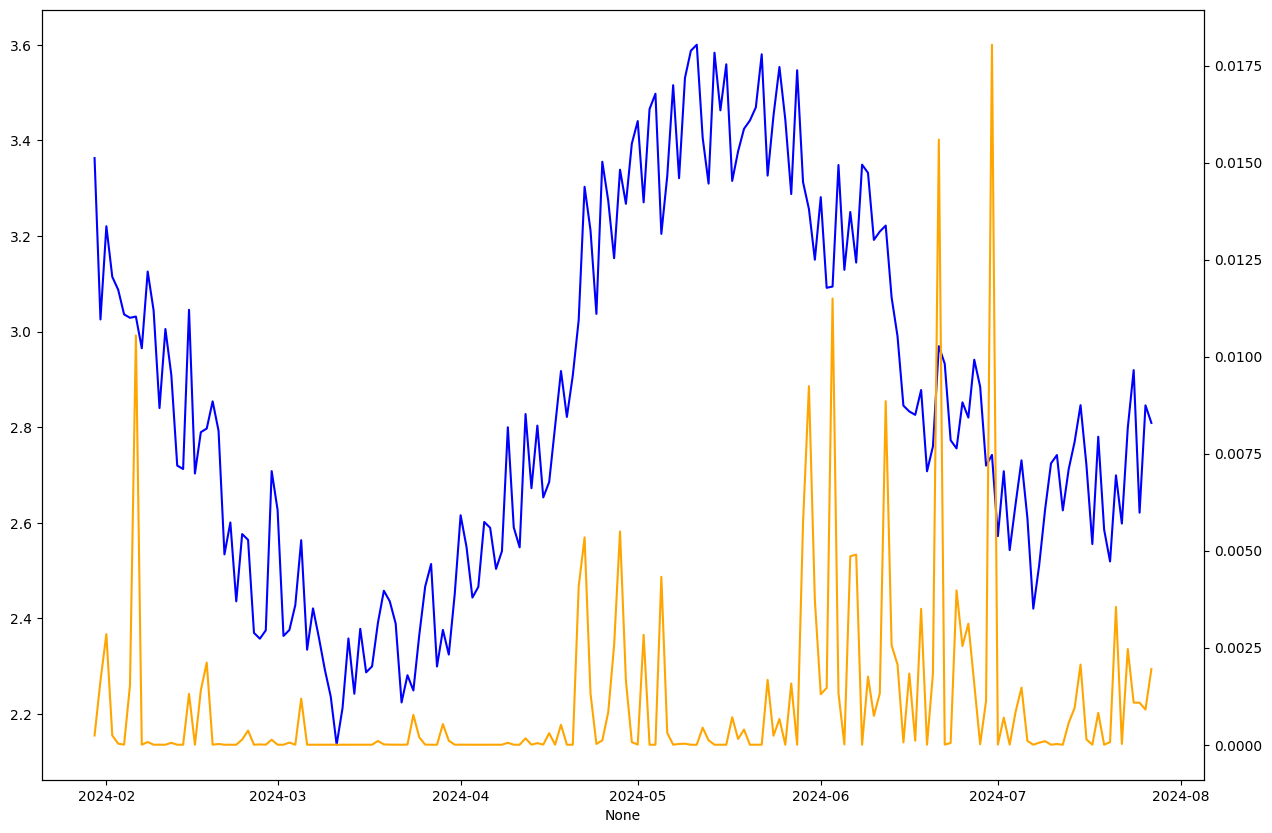

<ipython-input-16-22990e02c288>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


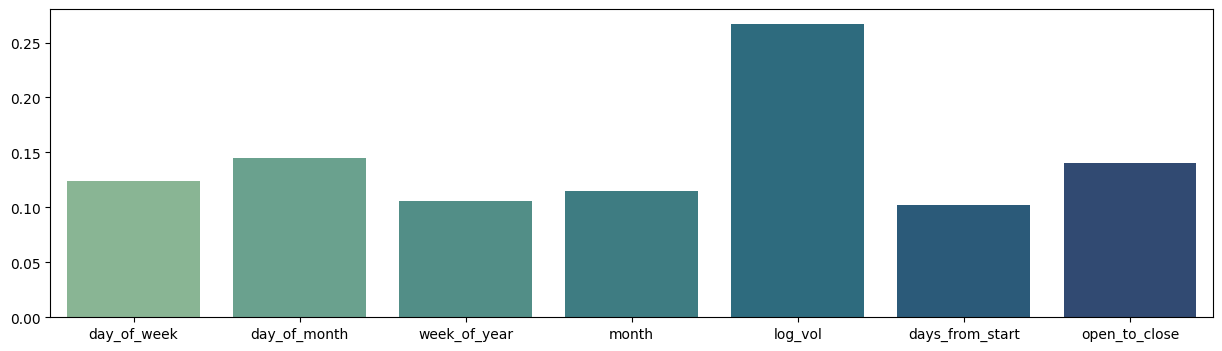

<ipython-input-16-22990e02c288>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


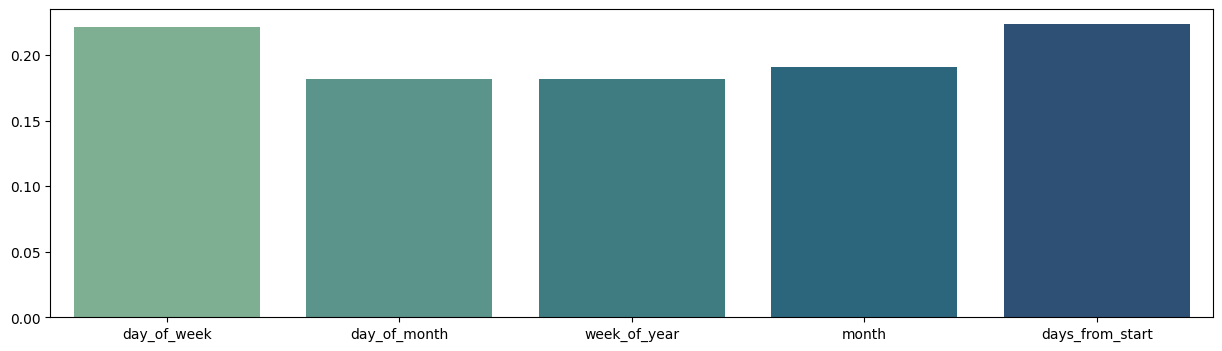


Plotting interpreation plots for a batch of entity 11:


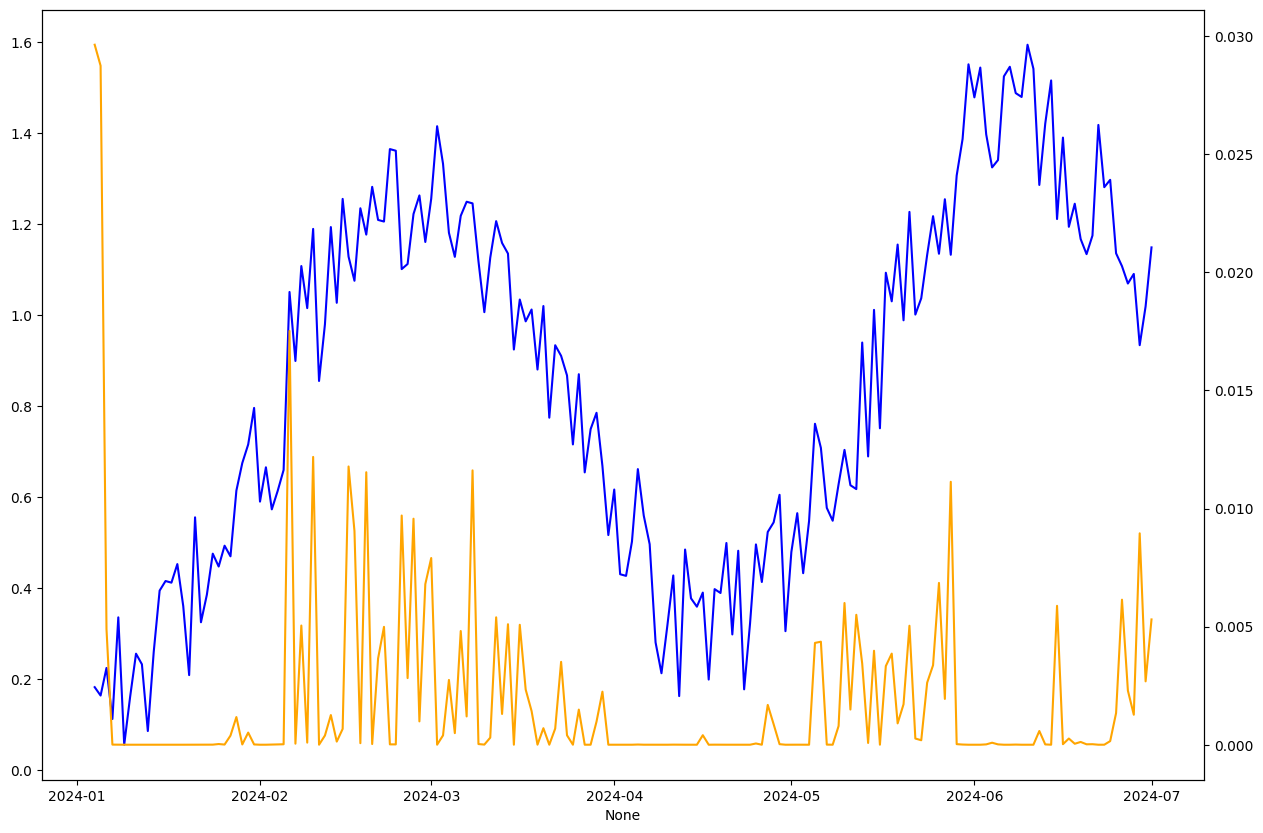

<ipython-input-16-22990e02c288>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


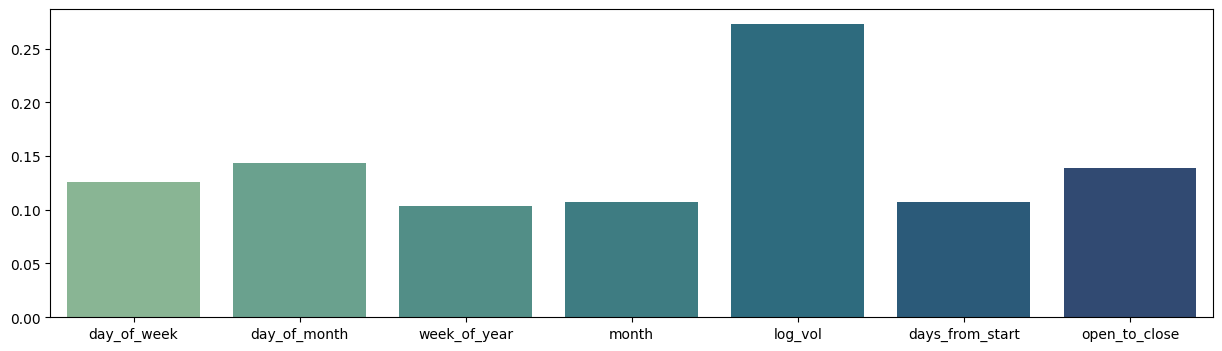

<ipython-input-16-22990e02c288>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


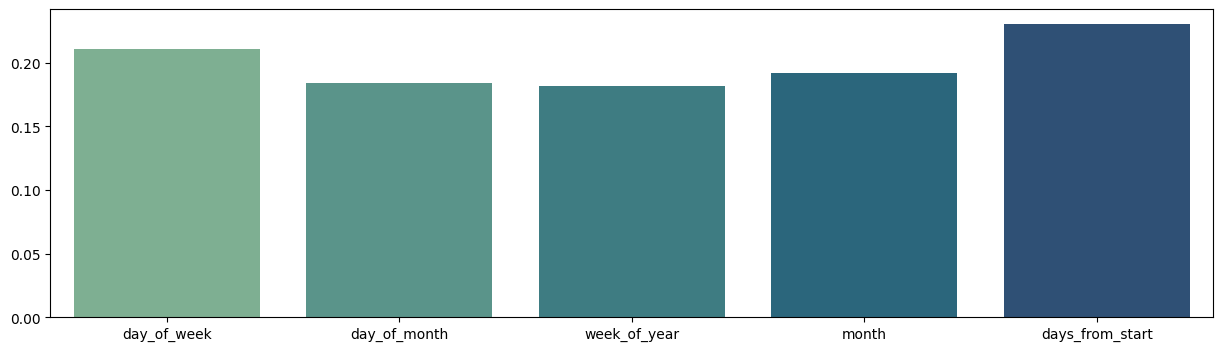


Plotting interpreation plots for a batch of entity 12:


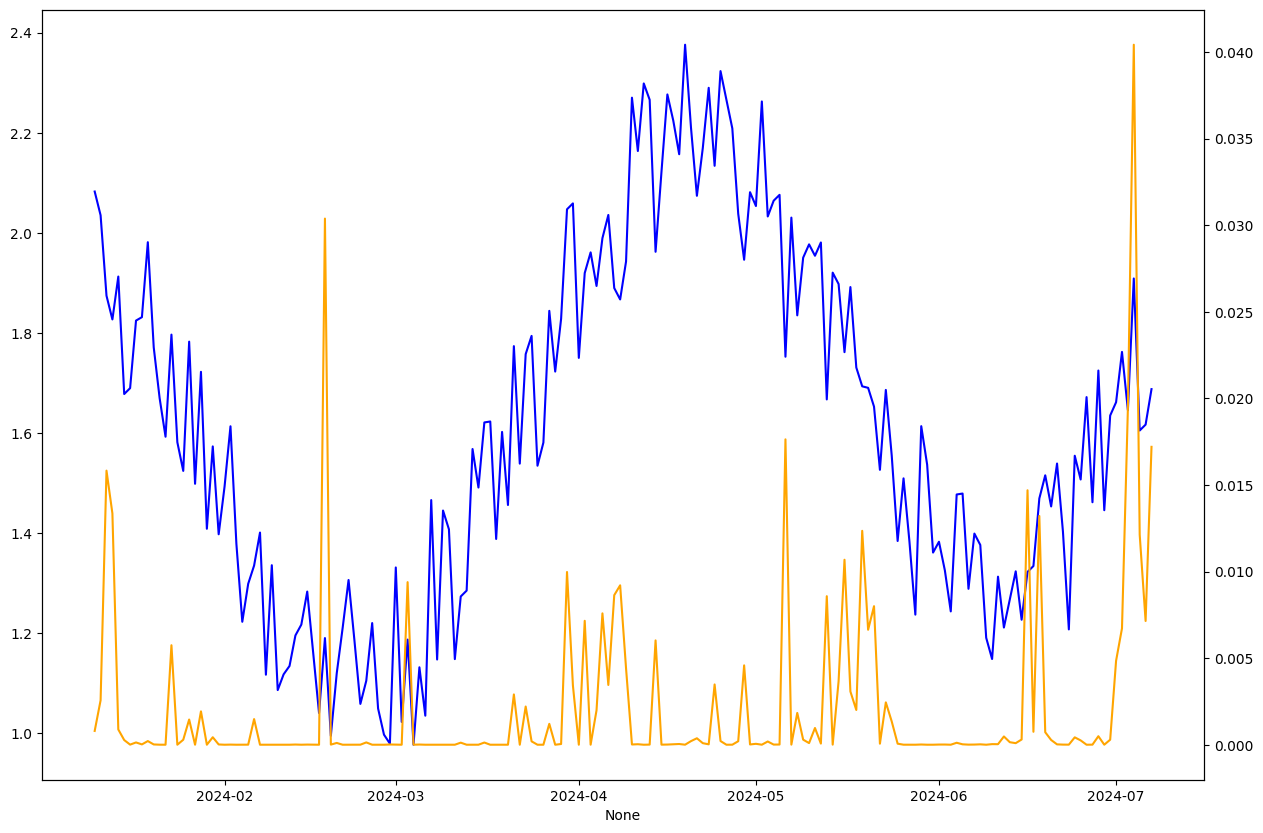

<ipython-input-16-22990e02c288>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


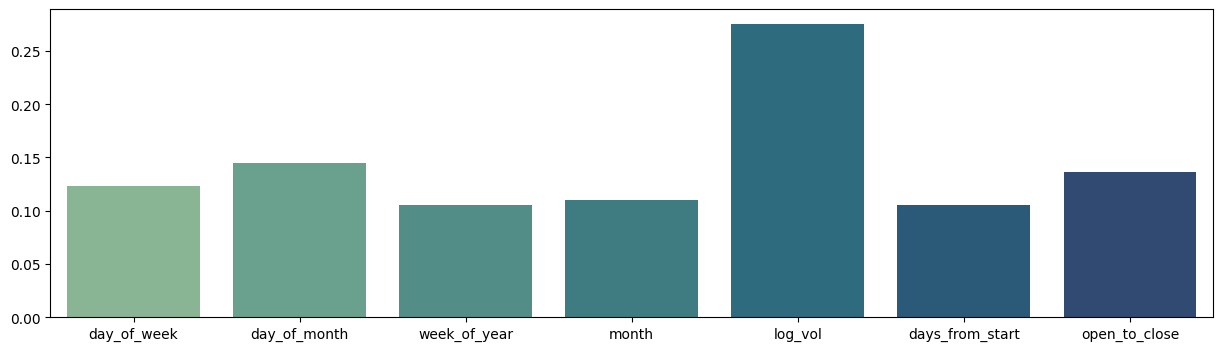

<ipython-input-16-22990e02c288>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


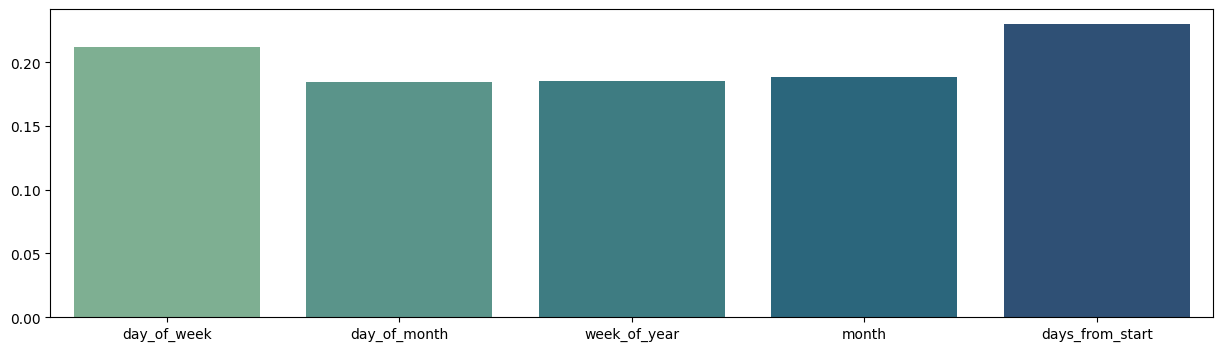


Plotting interpreation plots for a batch of entity 13:


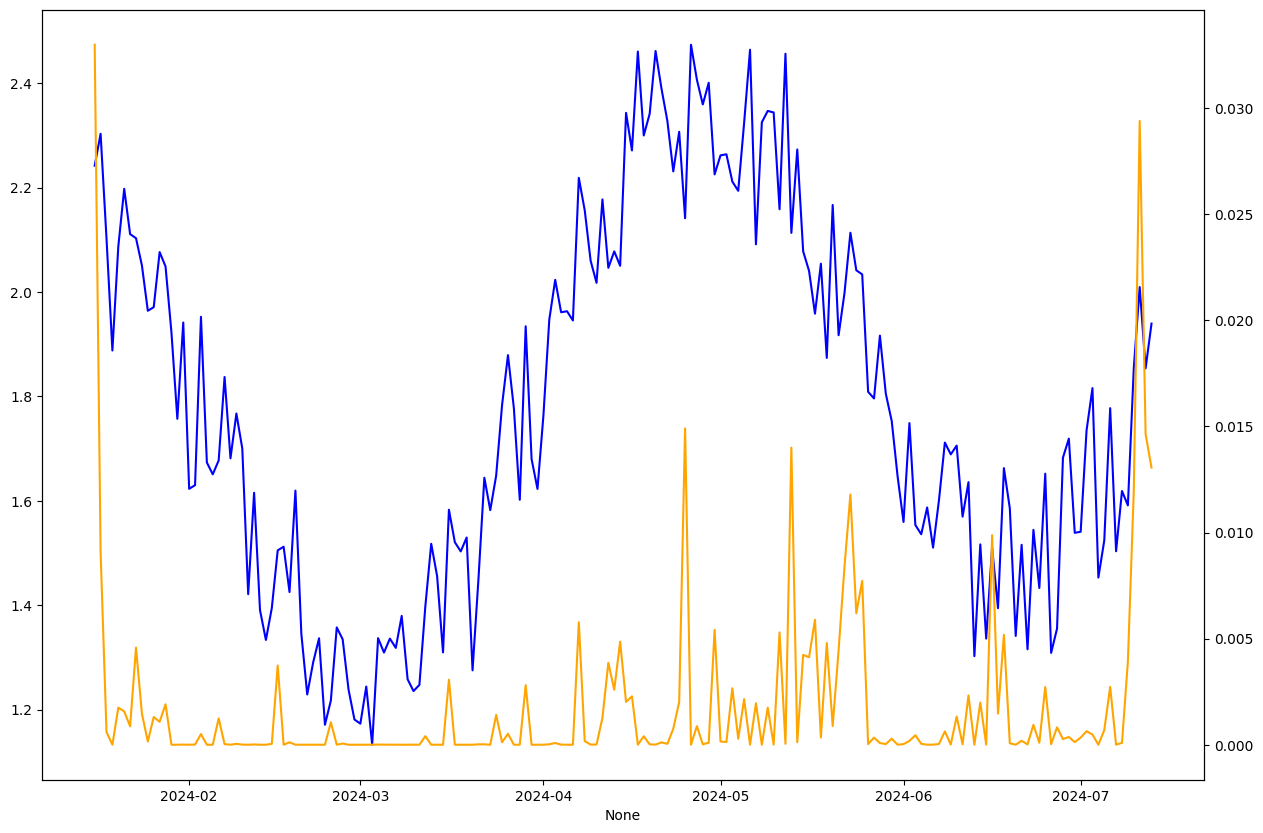

<ipython-input-16-22990e02c288>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


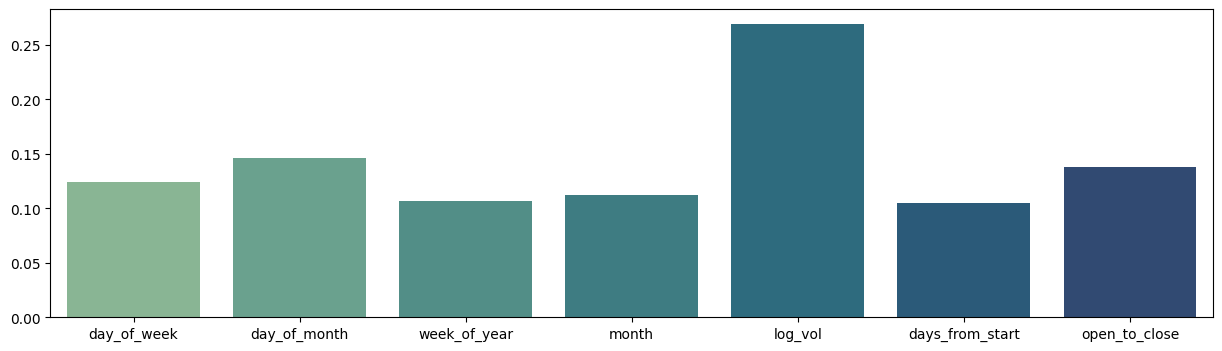

<ipython-input-16-22990e02c288>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


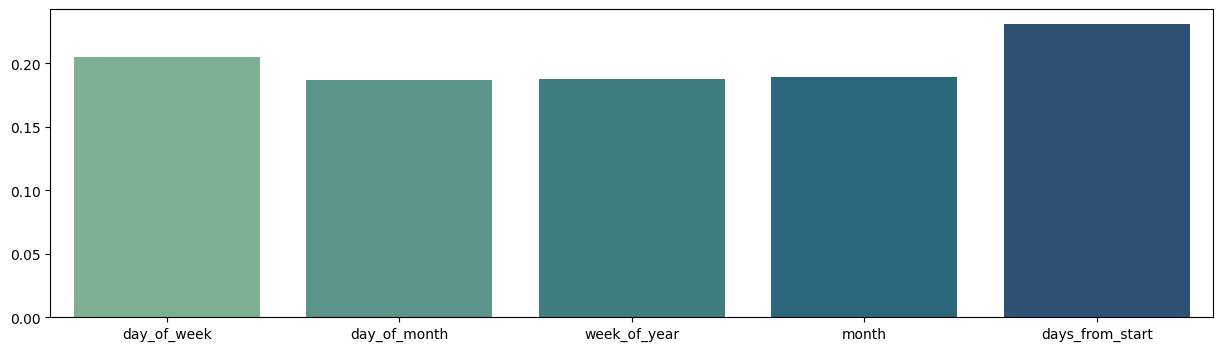


Plotting interpreation plots for a batch of entity 14:


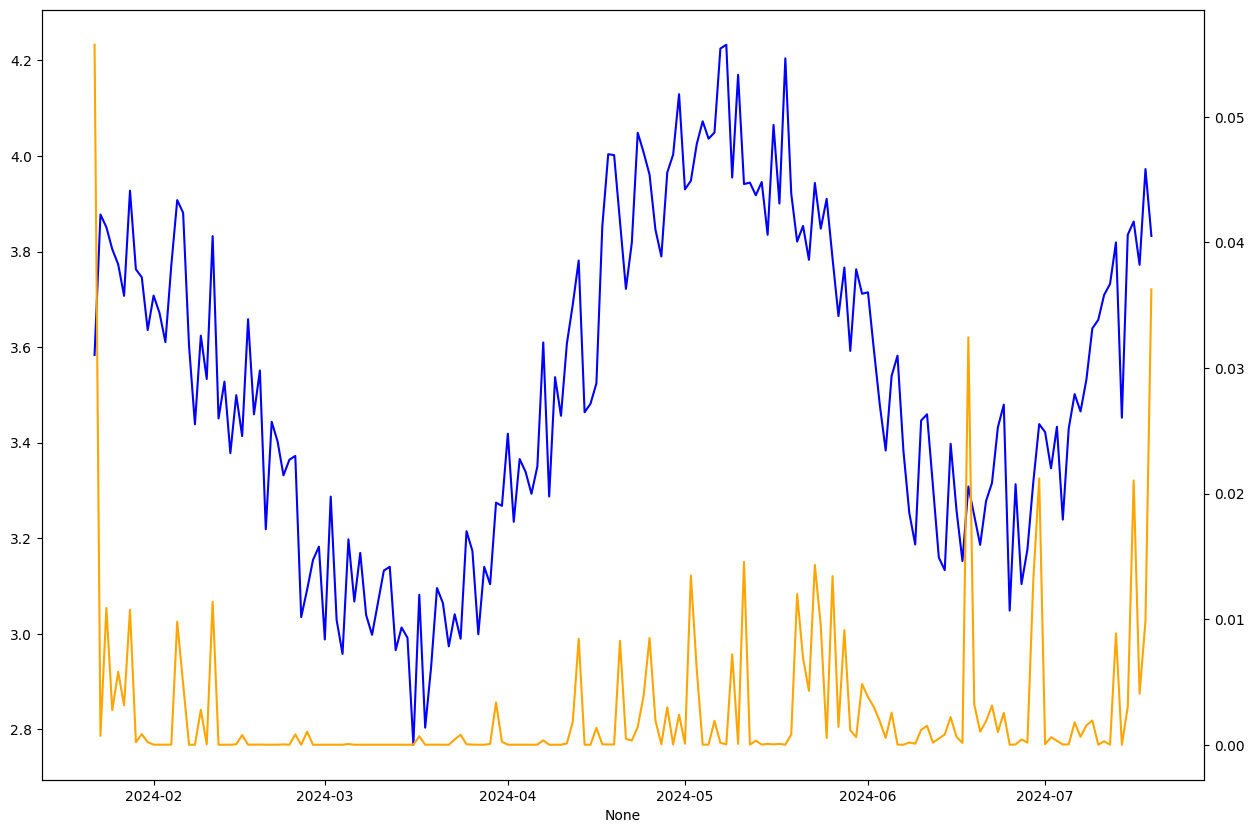

<ipython-input-16-22990e02c288>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


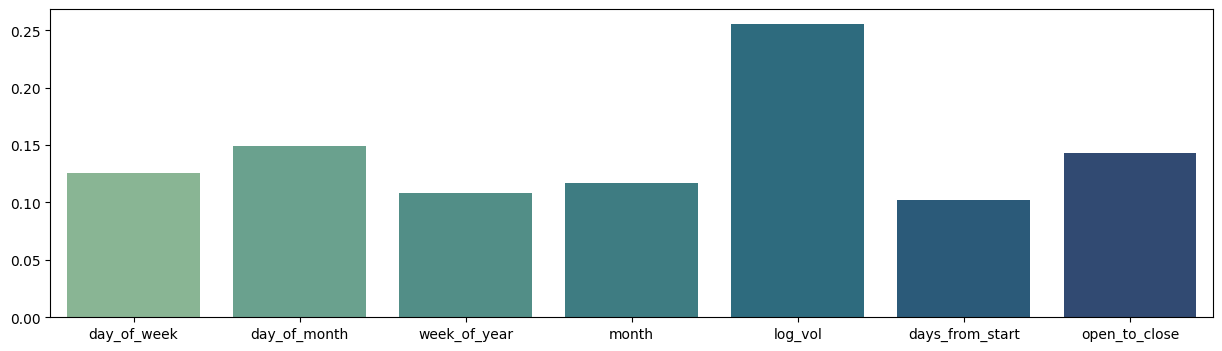

<ipython-input-16-22990e02c288>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


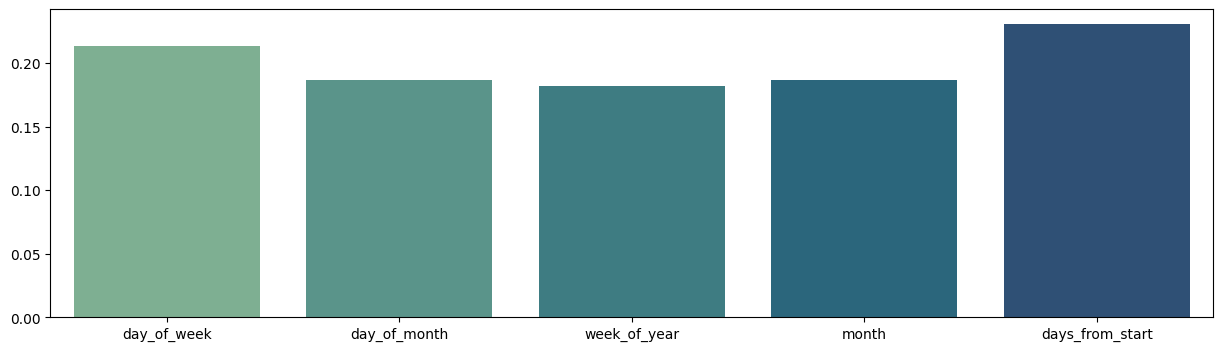


Plotting interpreation plots for a batch of entity 15:


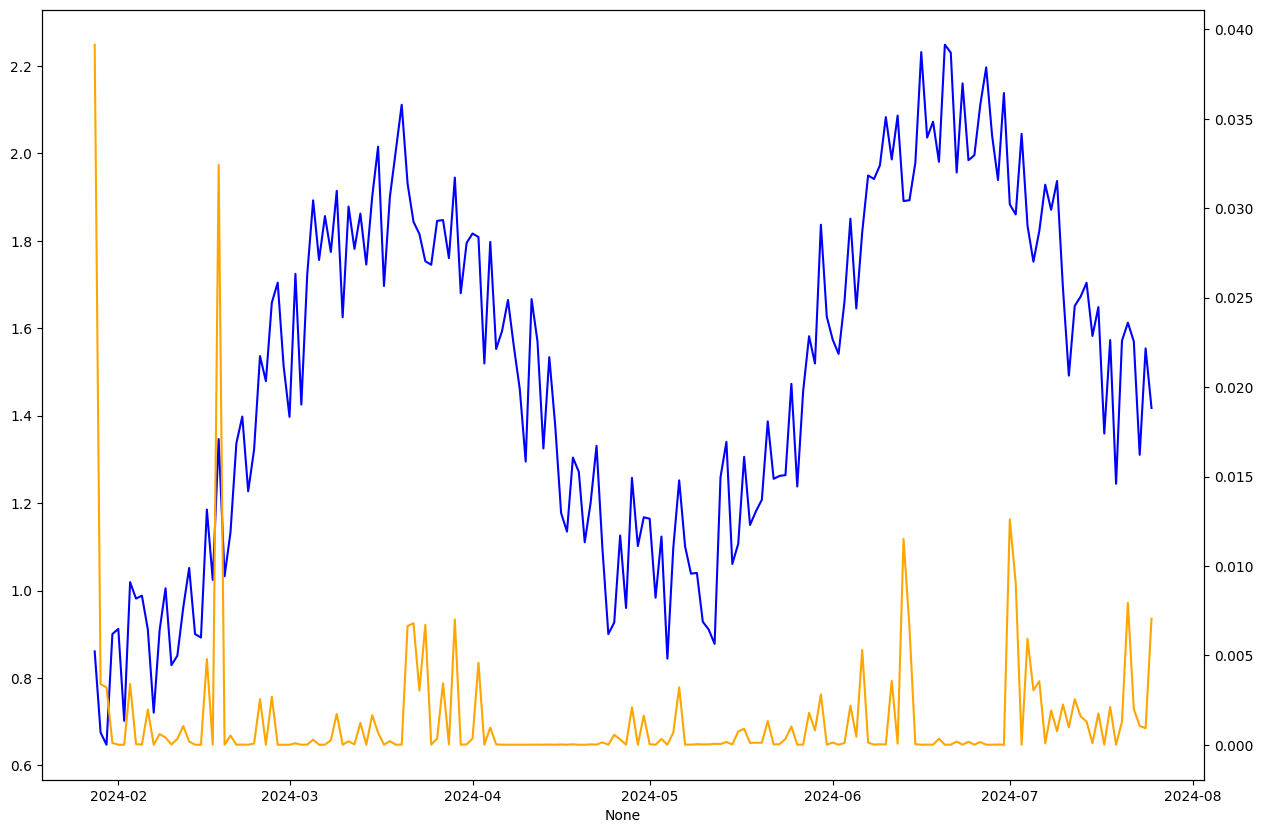

<ipython-input-16-22990e02c288>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


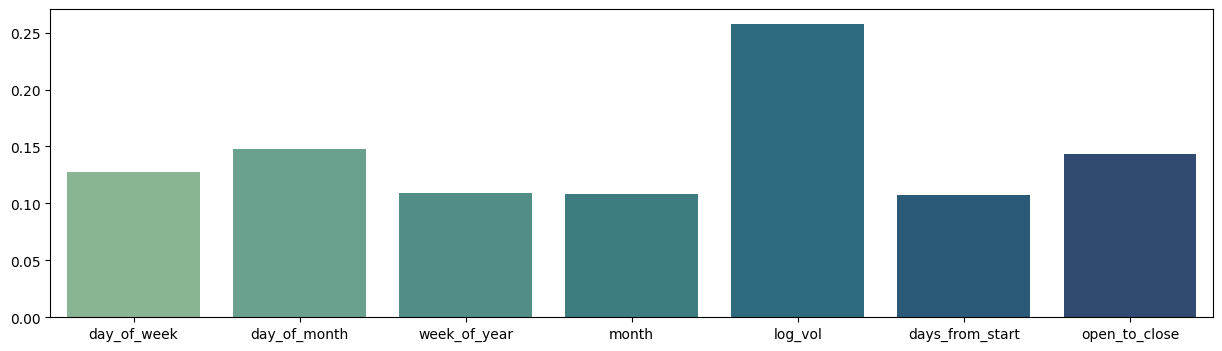

<ipython-input-16-22990e02c288>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


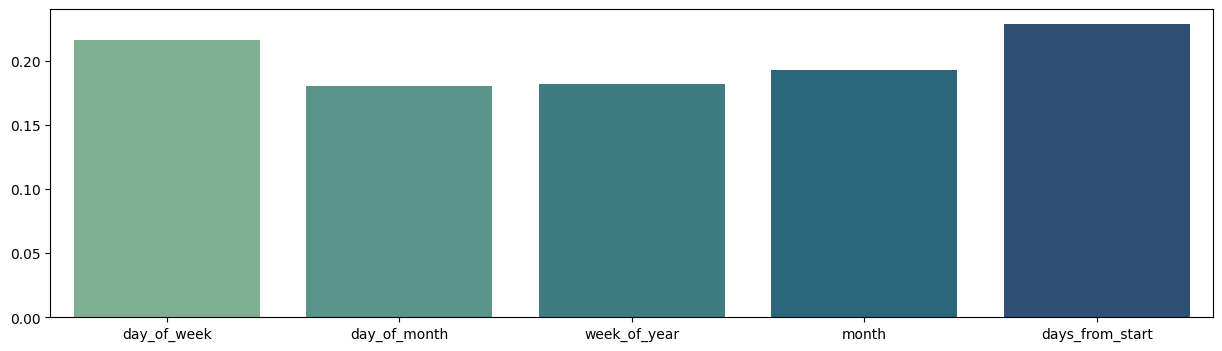

In [16]:
out_df = pd.DataFrame(columns=["p10", "p50", "p90", "identifier"])

start_id = -1

for i, batch in enumerate(test_dataloader):

    outputs, attention_weights = model(batch)
    bs = batch["outputs"].shape[0]

    process_map = {f"p{int(q * 100)}": outputs.reshape(bs, 5, 3)[:, :, i].cpu().detach().numpy()[::5,:].reshape(-1)[:bs] for i, q in enumerate(QUANTILES)}

    tmp = pd.DataFrame(data=process_map, index=pd.to_datetime(batch["time"][:, ENCODER_STEPS - 1, 0]))
    tmp["labels"] = batch["outputs"].reshape(-1)[::5]
    tmp["identifier"] = batch["identifier"][:, 0, 0]

    out_df = pd.concat([out_df, tmp])

    e = int(batch["identifier"][0, 0, 0].numpy())
    if batch["identifier"][0, 0, 0].numpy() != start_id:

        print("="*20)
        print(f"Plotting interpreation plots for a batch of entity {e}:")

        id_mask = batch["identifier"][:, 0, 0]==e

        #Plotting multi-head attention
        plt.figure(figsize=(15,10))
        sns.lineplot(x=pd.to_datetime(batch["time"][0,:,0].numpy()),
                     y=batch["inputs"][0,:,0].numpy(), color="blue")
        ax2 = plt.twinx()
        sns.lineplot(x=pd.to_datetime(batch["time"][0,:,0].numpy()),
                     y=attention_weights["multihead_attention"][0].cpu().detach().numpy()[:, 175:].mean(axis=1),
                     ax=ax2, color="orange")
        plt.show()

        past_inputs = ["day_of_week", "day_of_month", "week_of_year", "month", "log_vol", "days_from_start", "open_to_close"]
        future_inputs = ["day_of_week", "day_of_month", "week_of_year", "month", "days_from_start"]

        # Plotting past weights
        plt.figure(figsize=(15,4))
        sns.barplot(x=past_inputs,
                    y=attention_weights["past_weights"][id_mask,:,:].mean(dim=(0,1)).cpu().detach().numpy(),
                    palette="crest")
        plt.show()

        # Plotting future weights
        plt.figure(figsize=(15,4))
        sns.barplot(x=future_inputs,
                    y=attention_weights["future_weights"][id_mask,:,:].mean(dim=(0,1)).cpu().detach().numpy(),
                    palette="crest")
        plt.show()
        start_id = e
        print()

In [17]:
# for i in range(5):
#     plt.figure(figsize=(20,10))
#     sns.lineplot(x=test[test["Entity"]==i].iloc[:ENCODER_STEPS-1]["date"], y=test[test["Entity"]==i].iloc[:ENCODER_STEPS-1]["traffic"])
#     sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].labels, color="black")
#     sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p10, color="red")
#     sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p50, color="orange")
#     sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p90, color="green")

#     plt.fill_between(out_df[out_df["identifier"]==i].index, out_df[out_df["identifier"]==i].p10, out_df[out_df["identifier"]==i].p90, alpha=0.3)

#     plt.show()

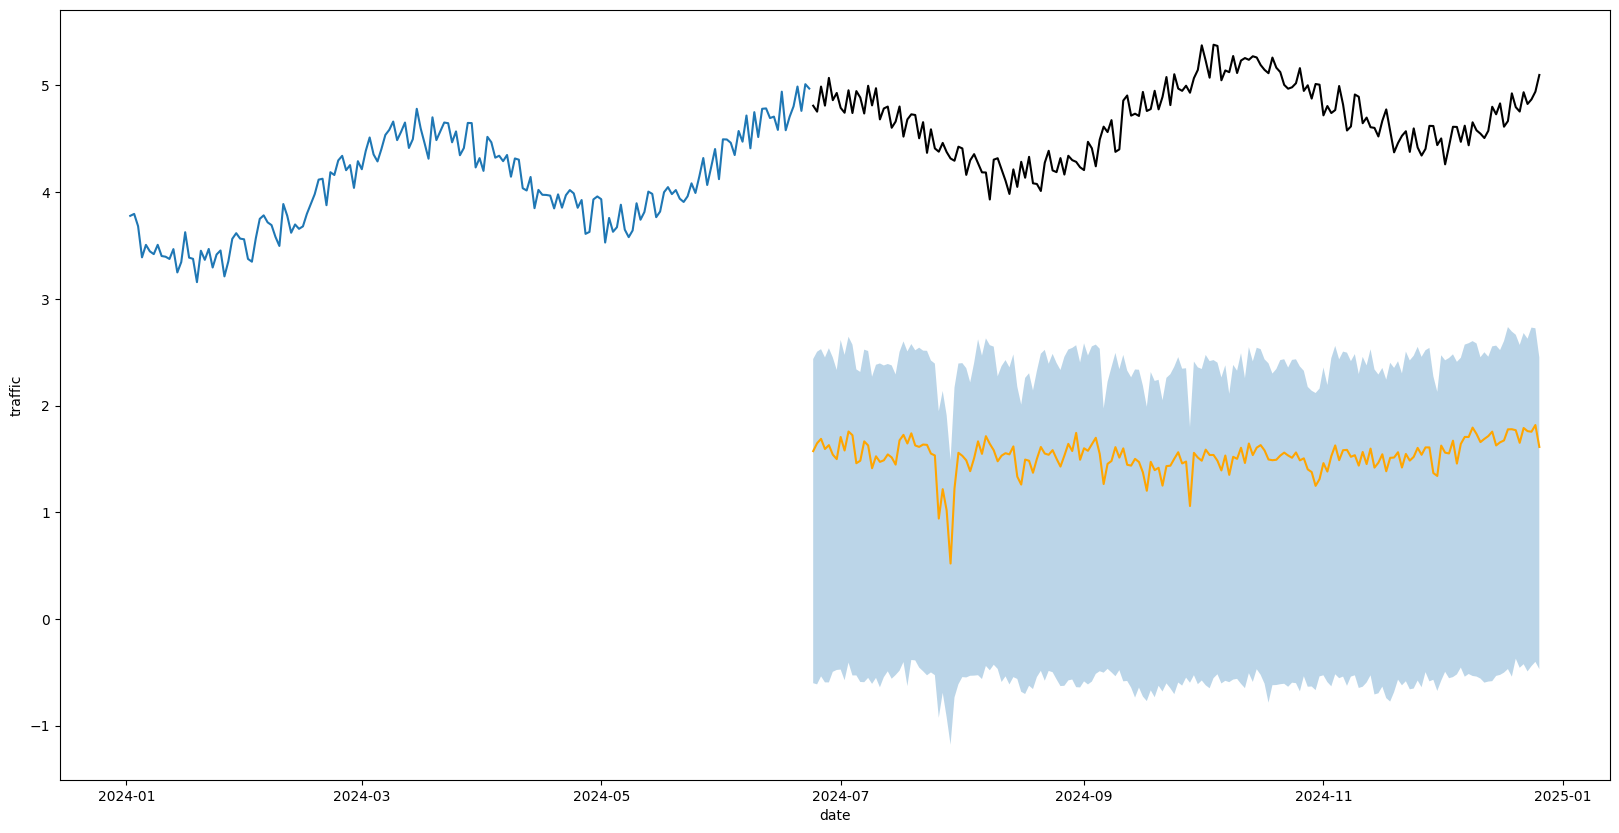

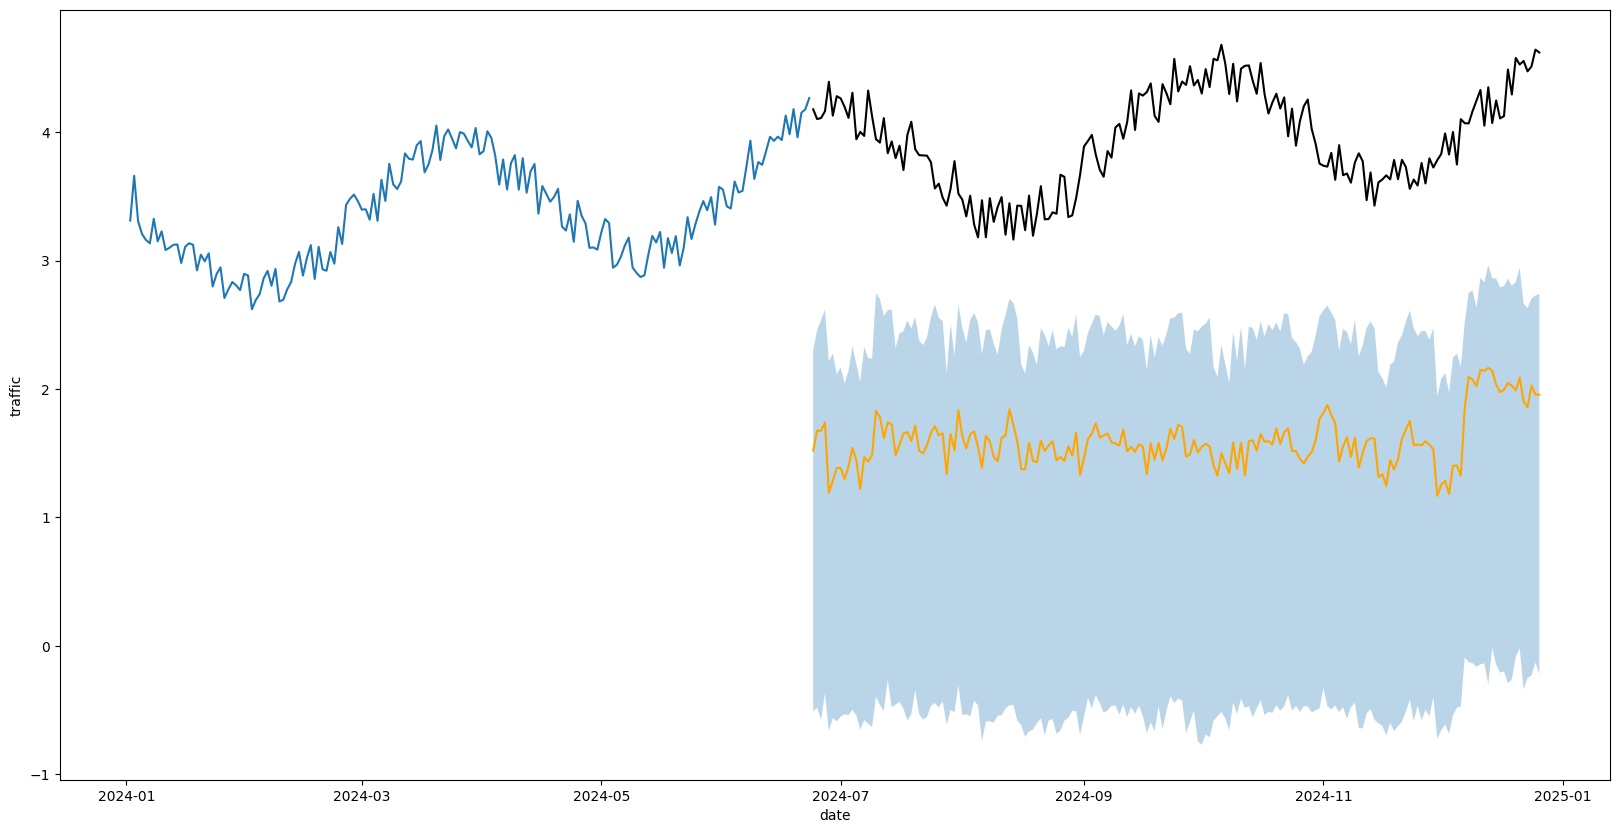

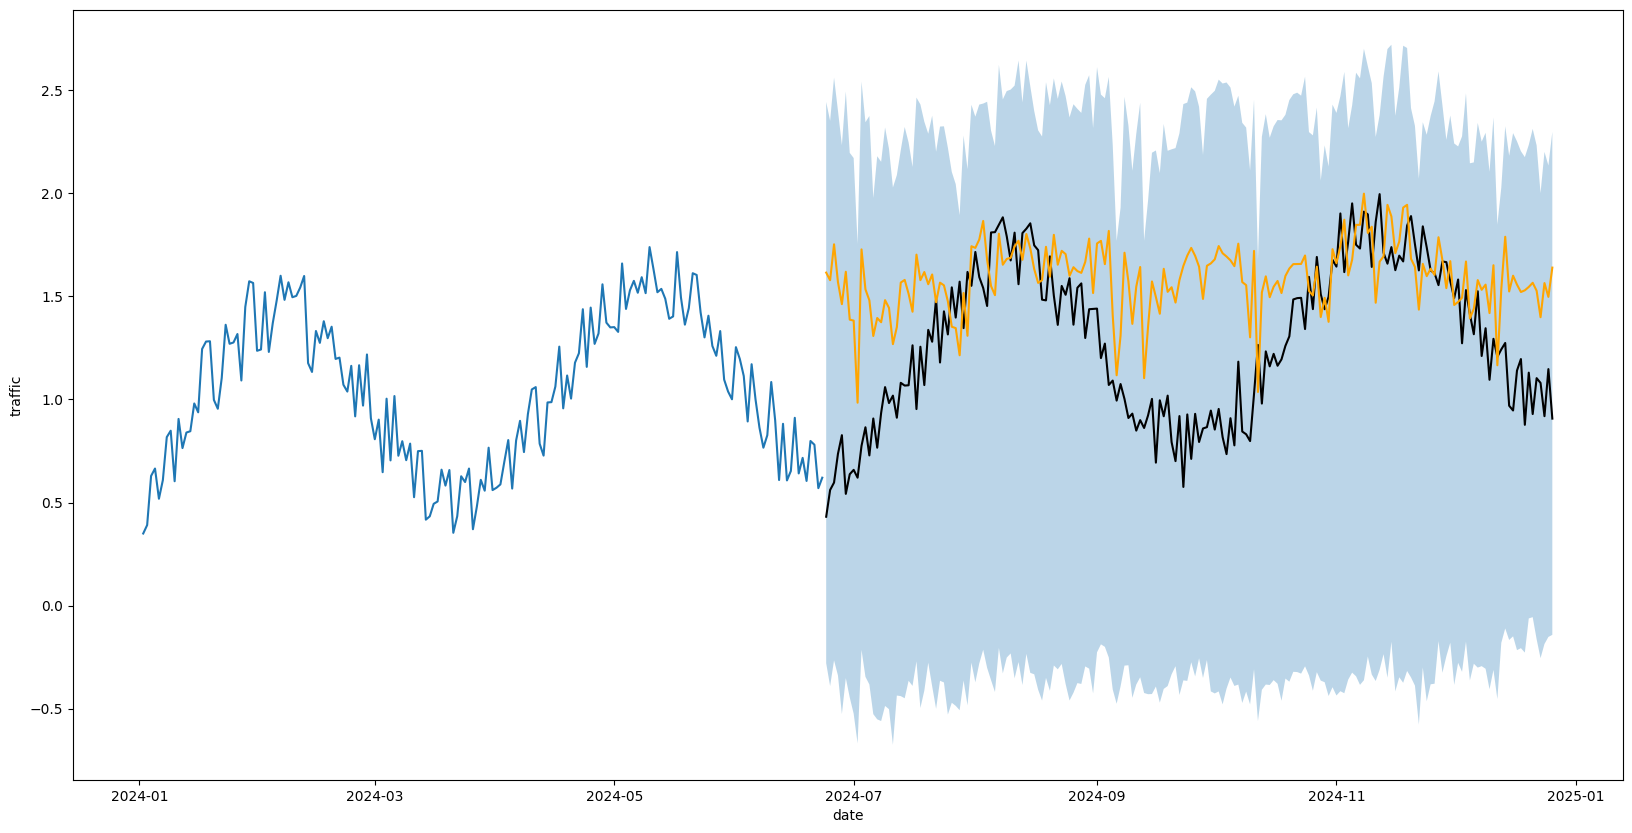

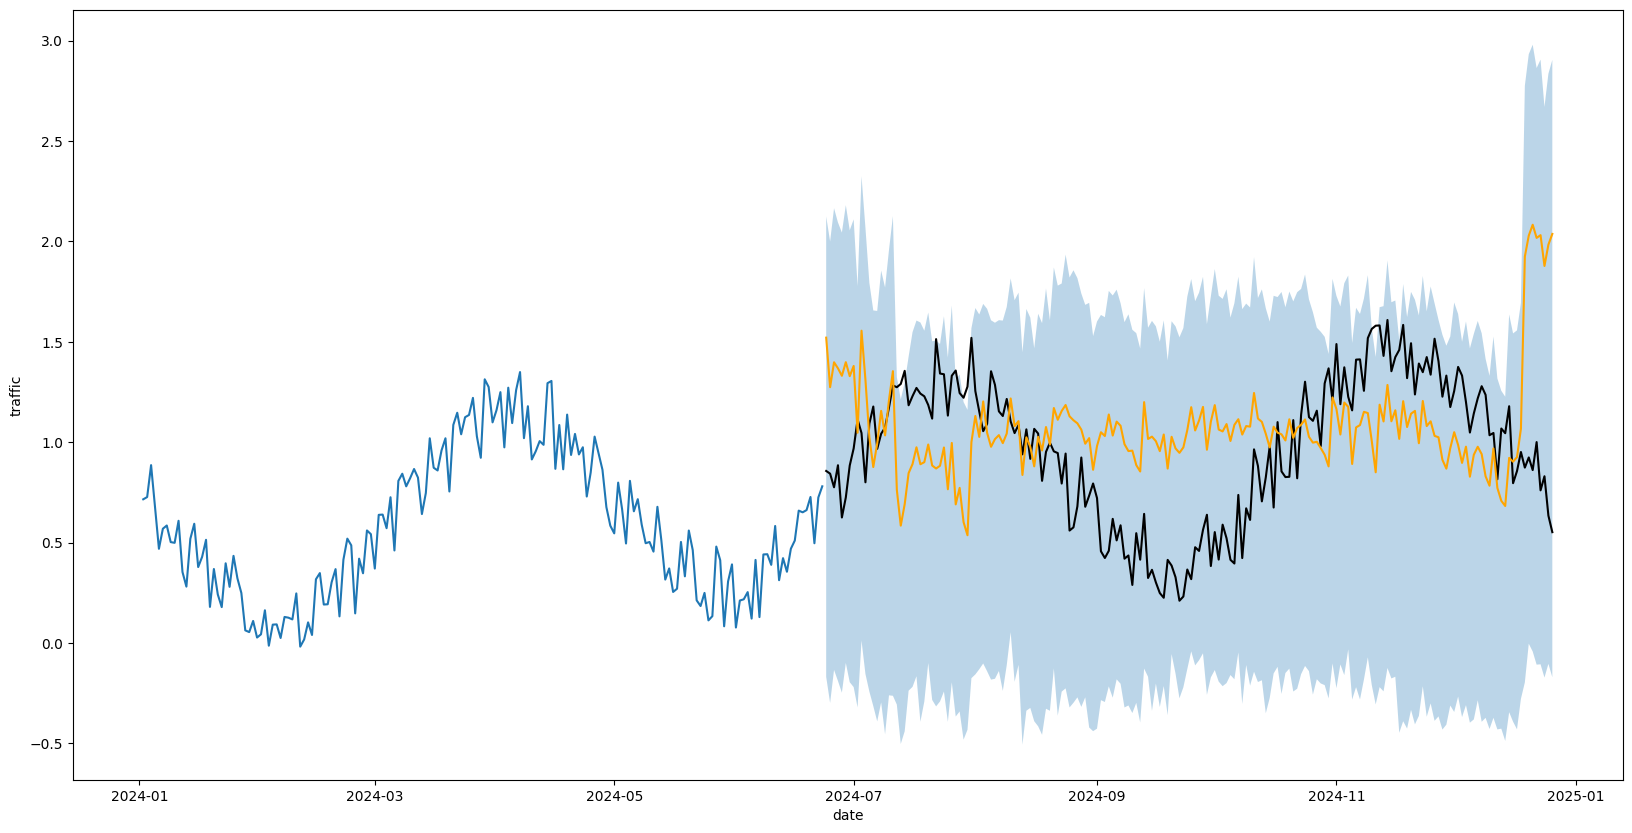

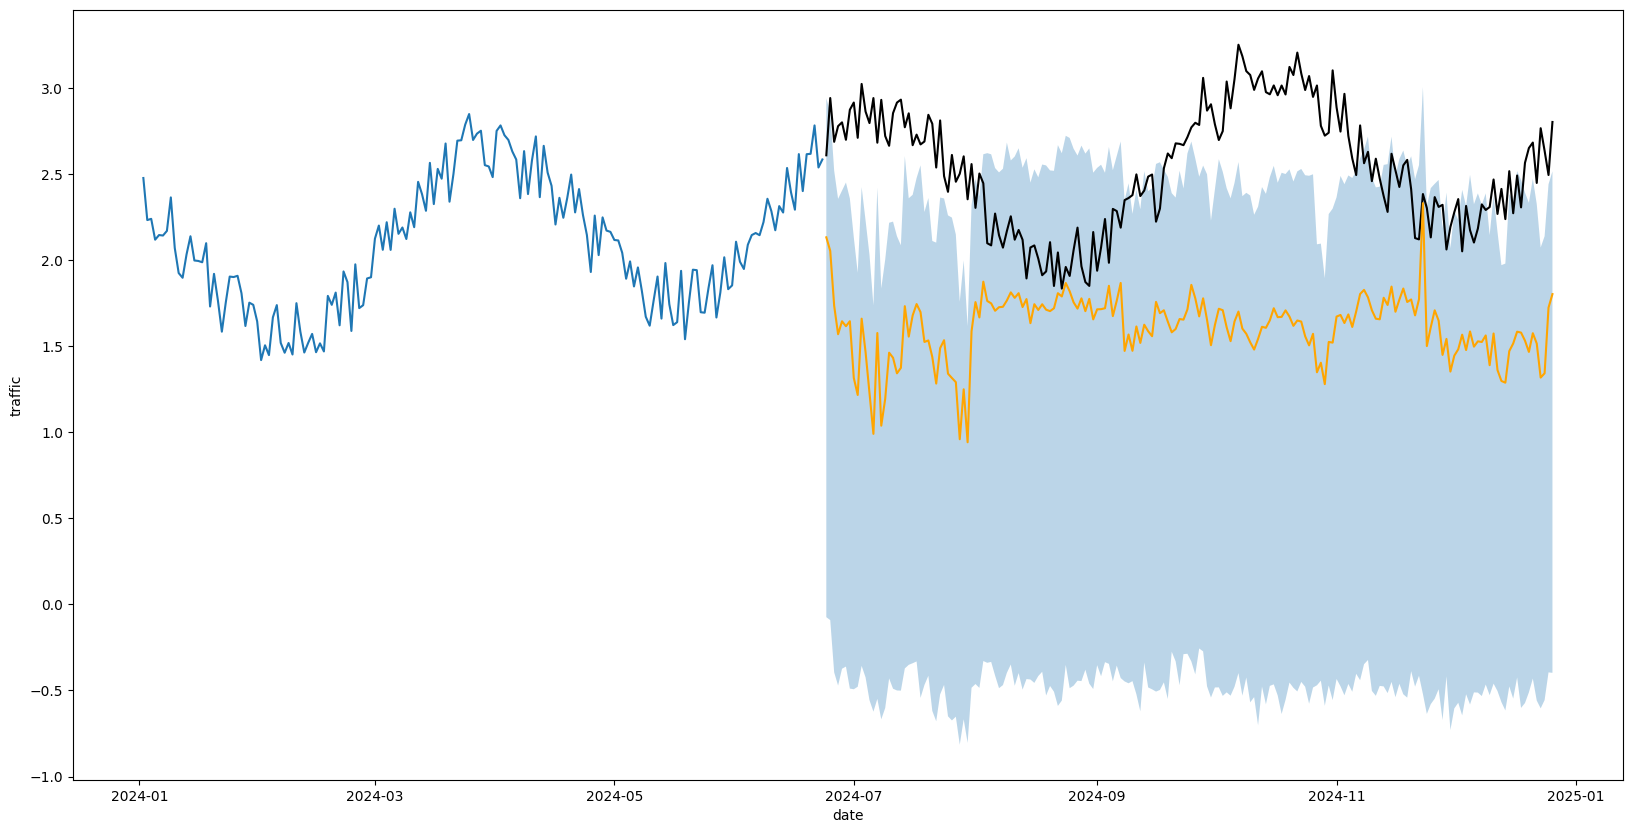

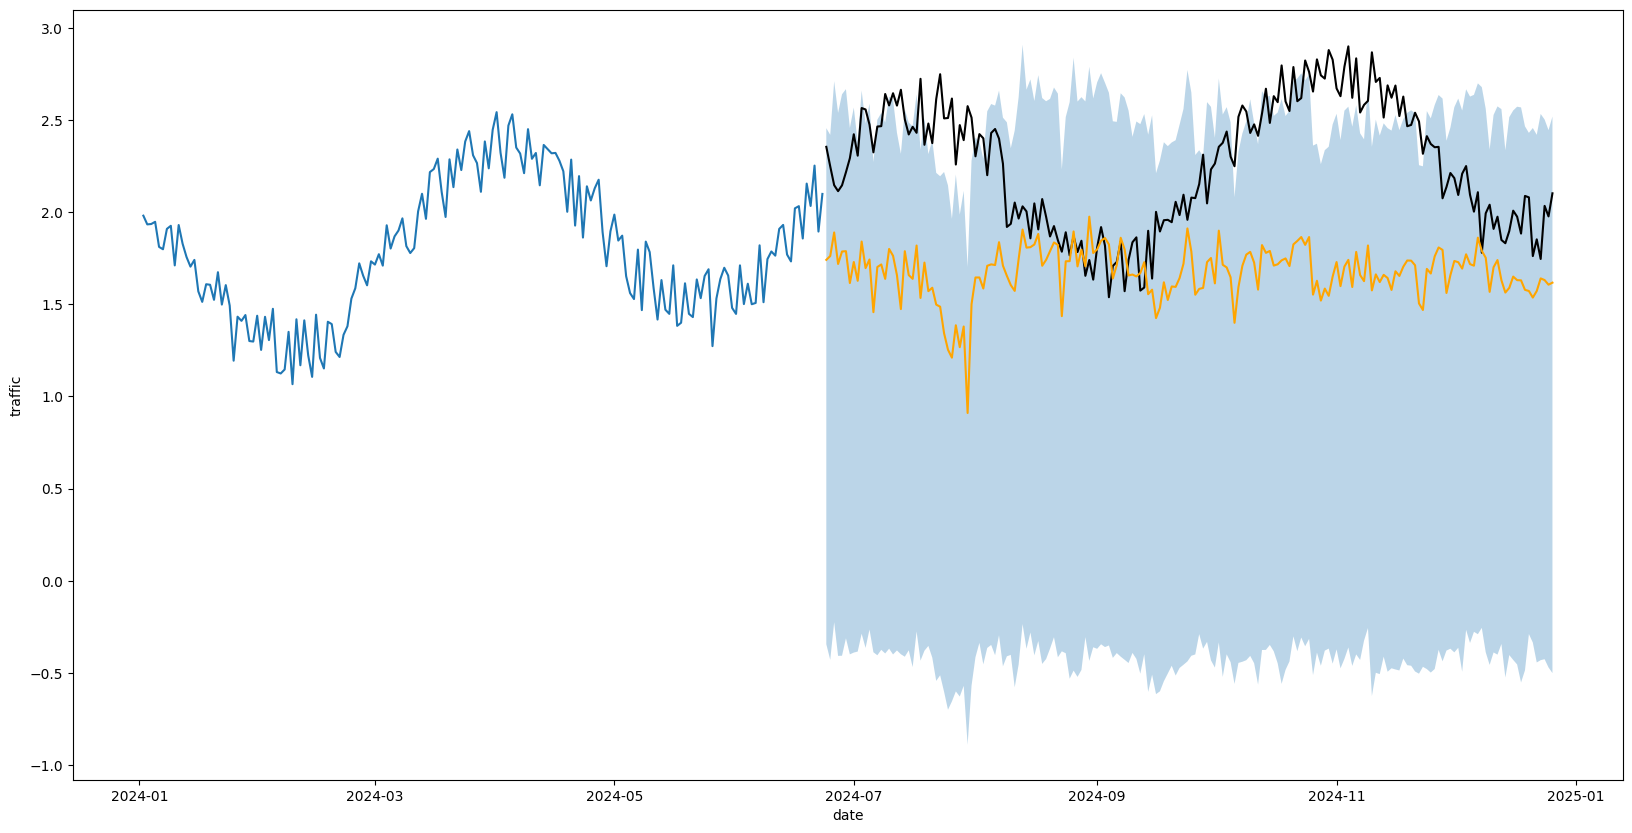

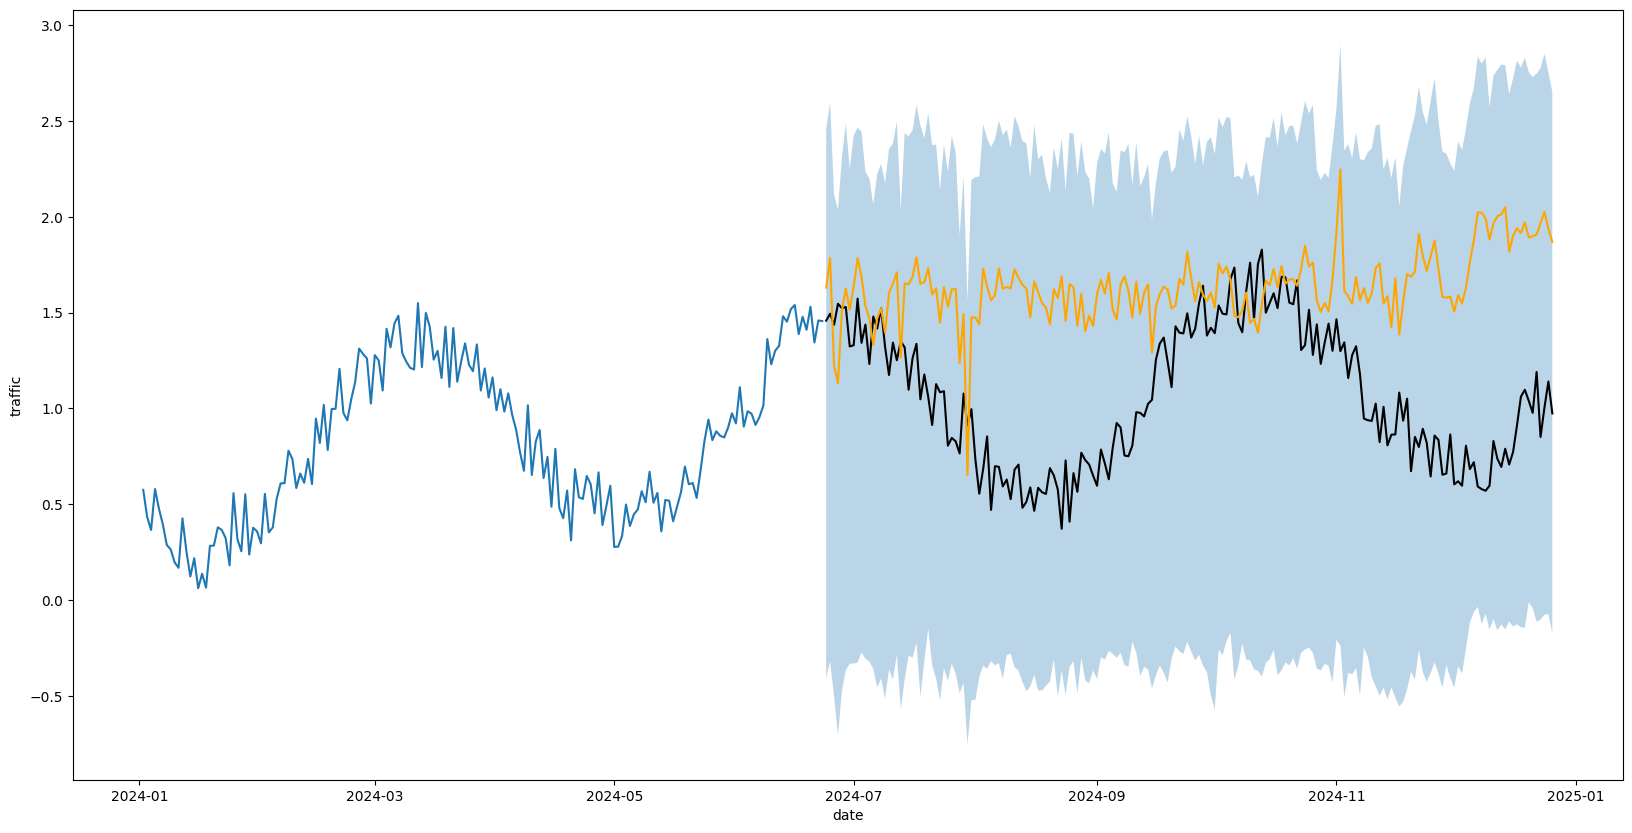

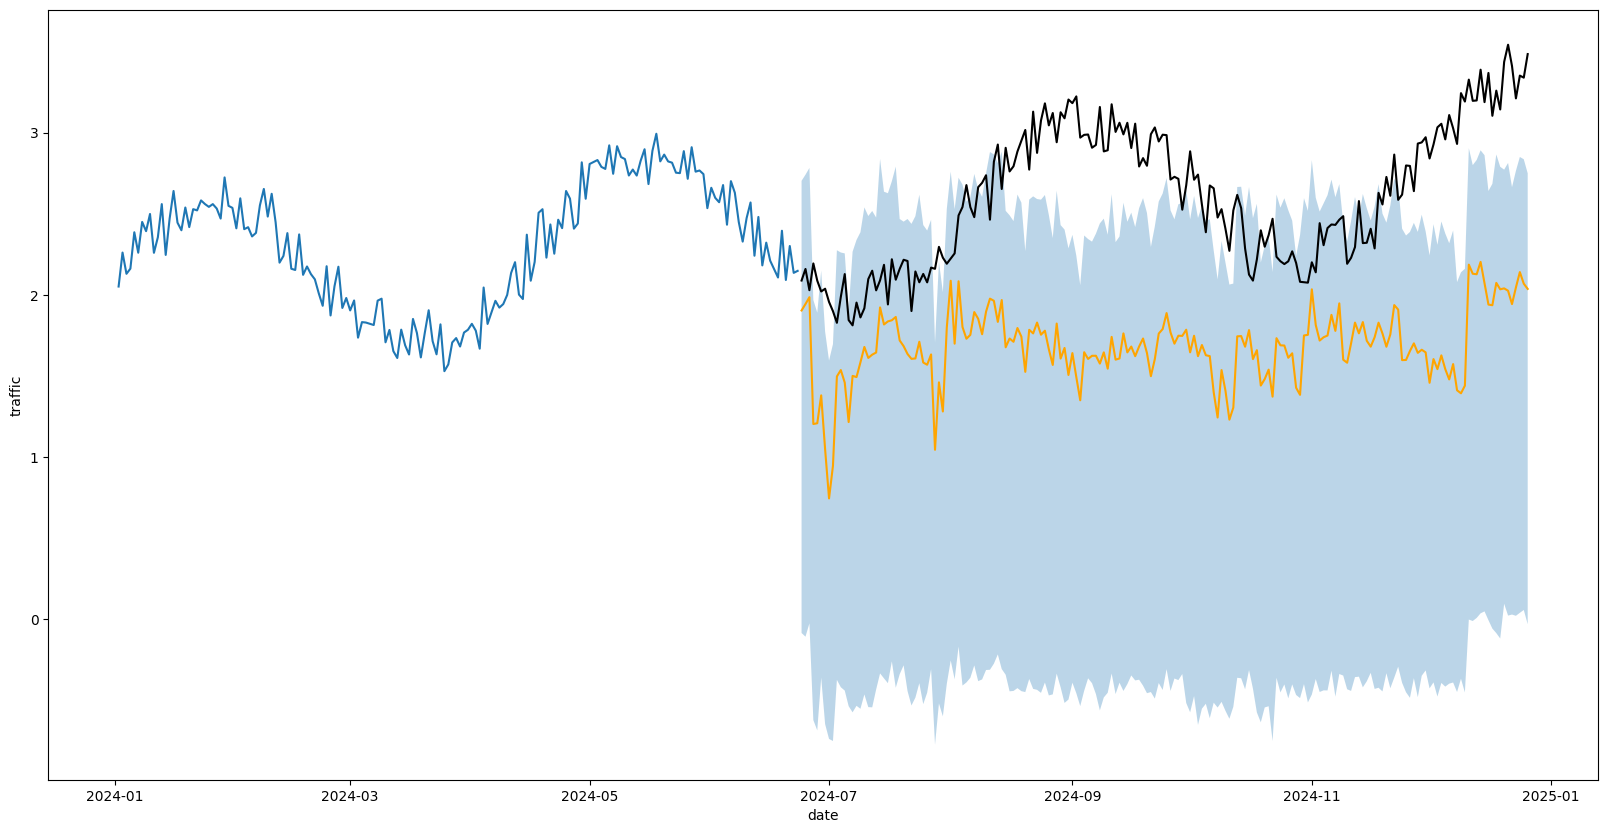

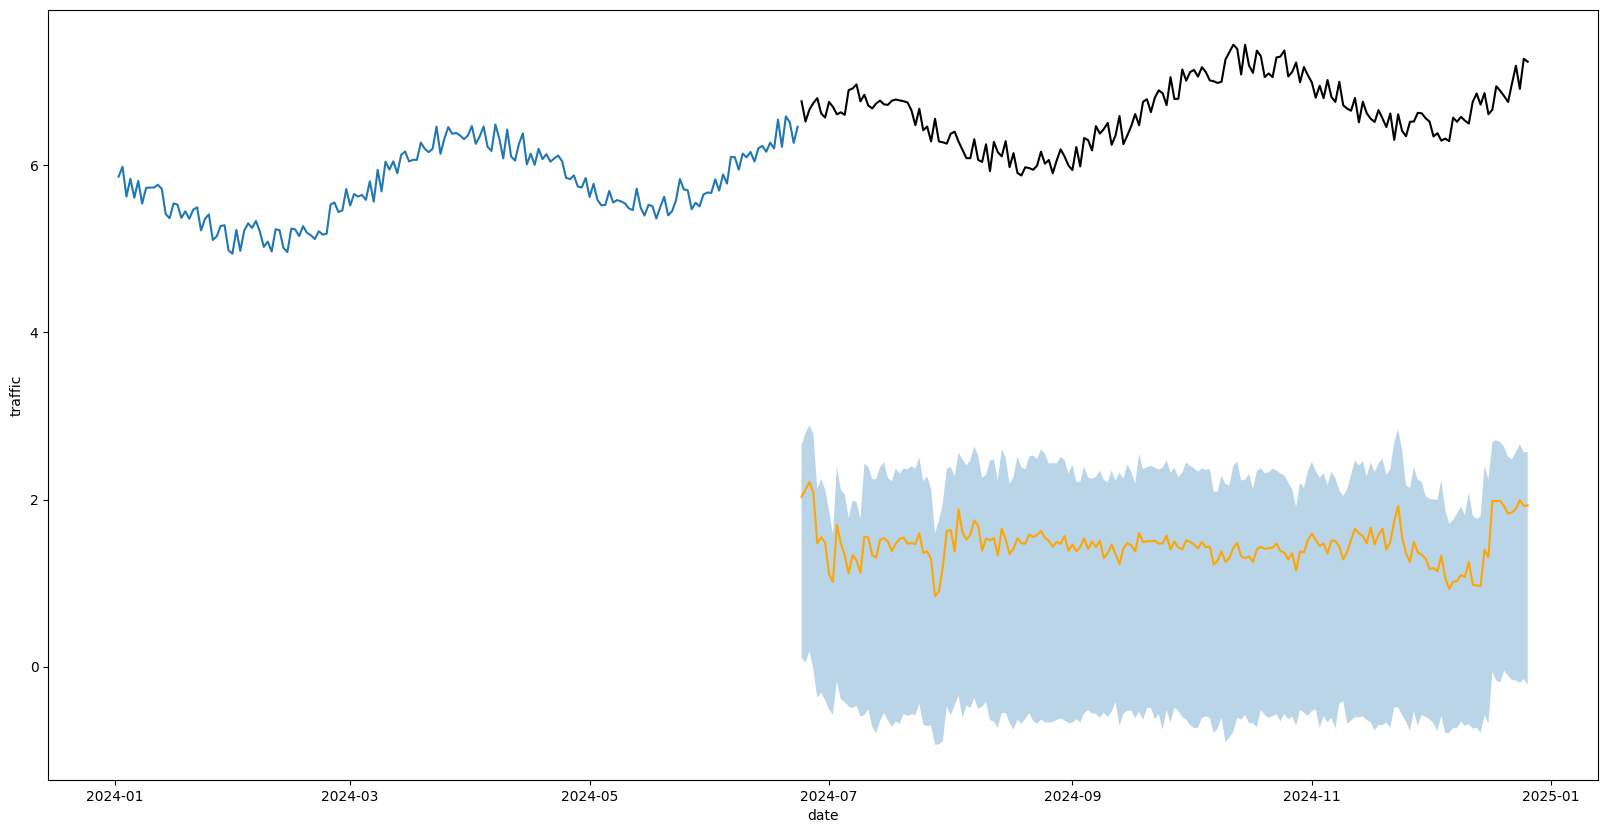

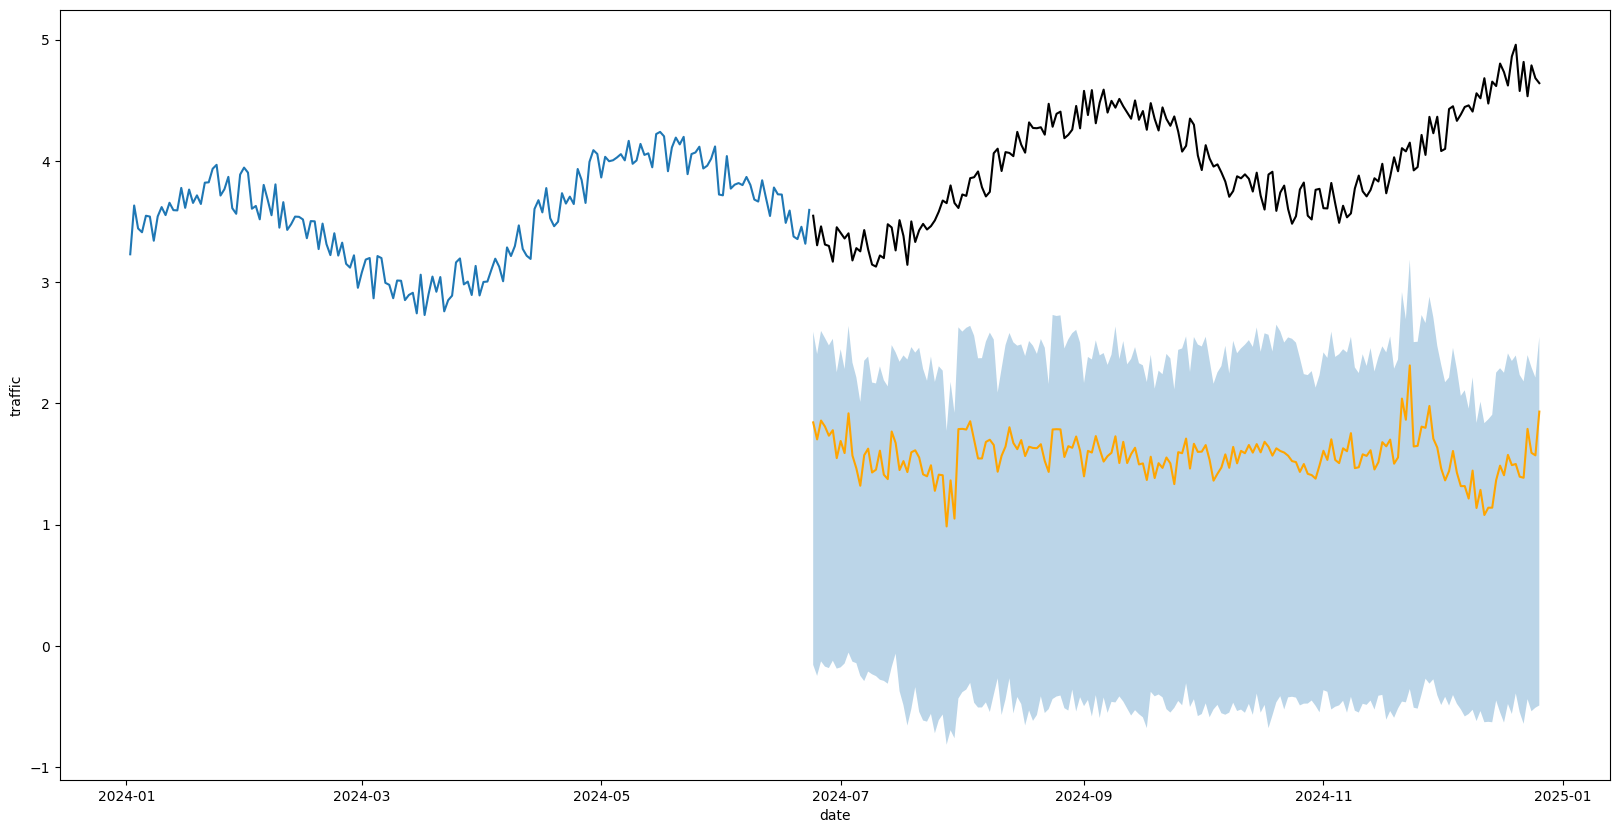

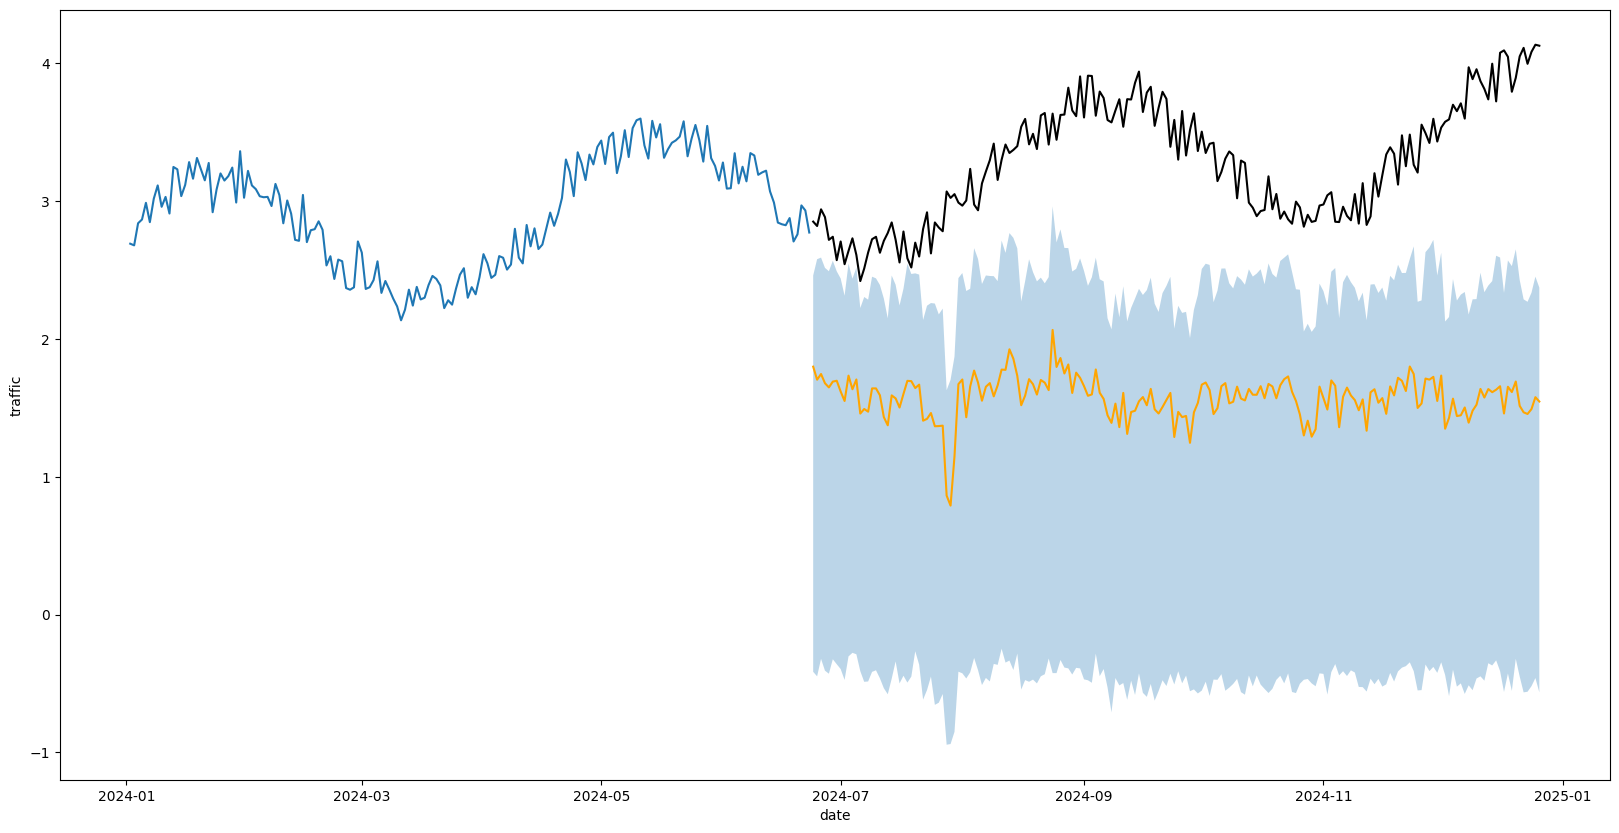

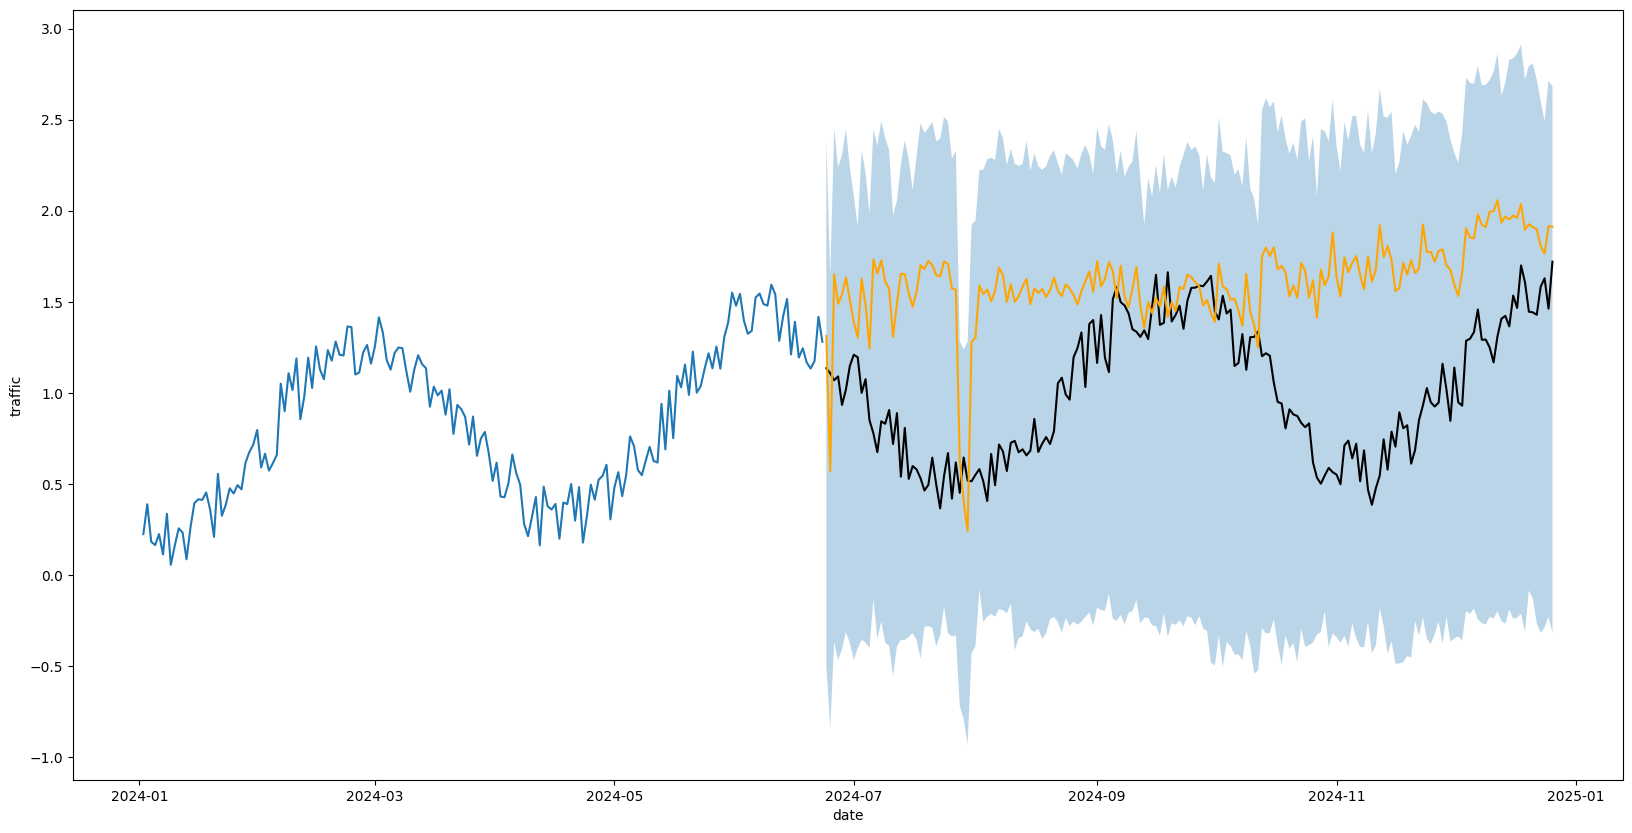

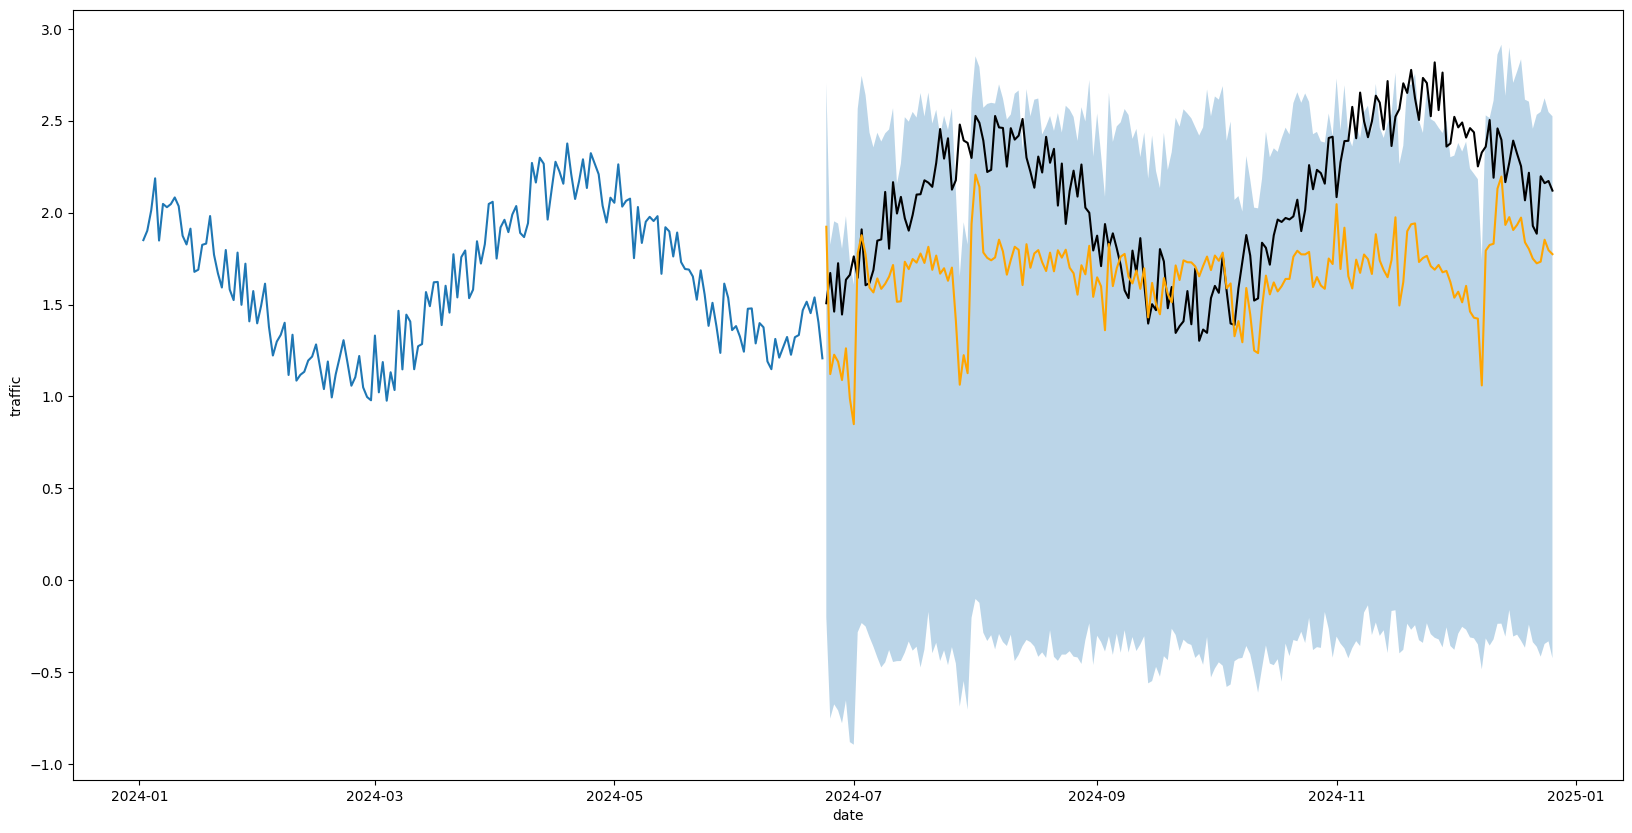

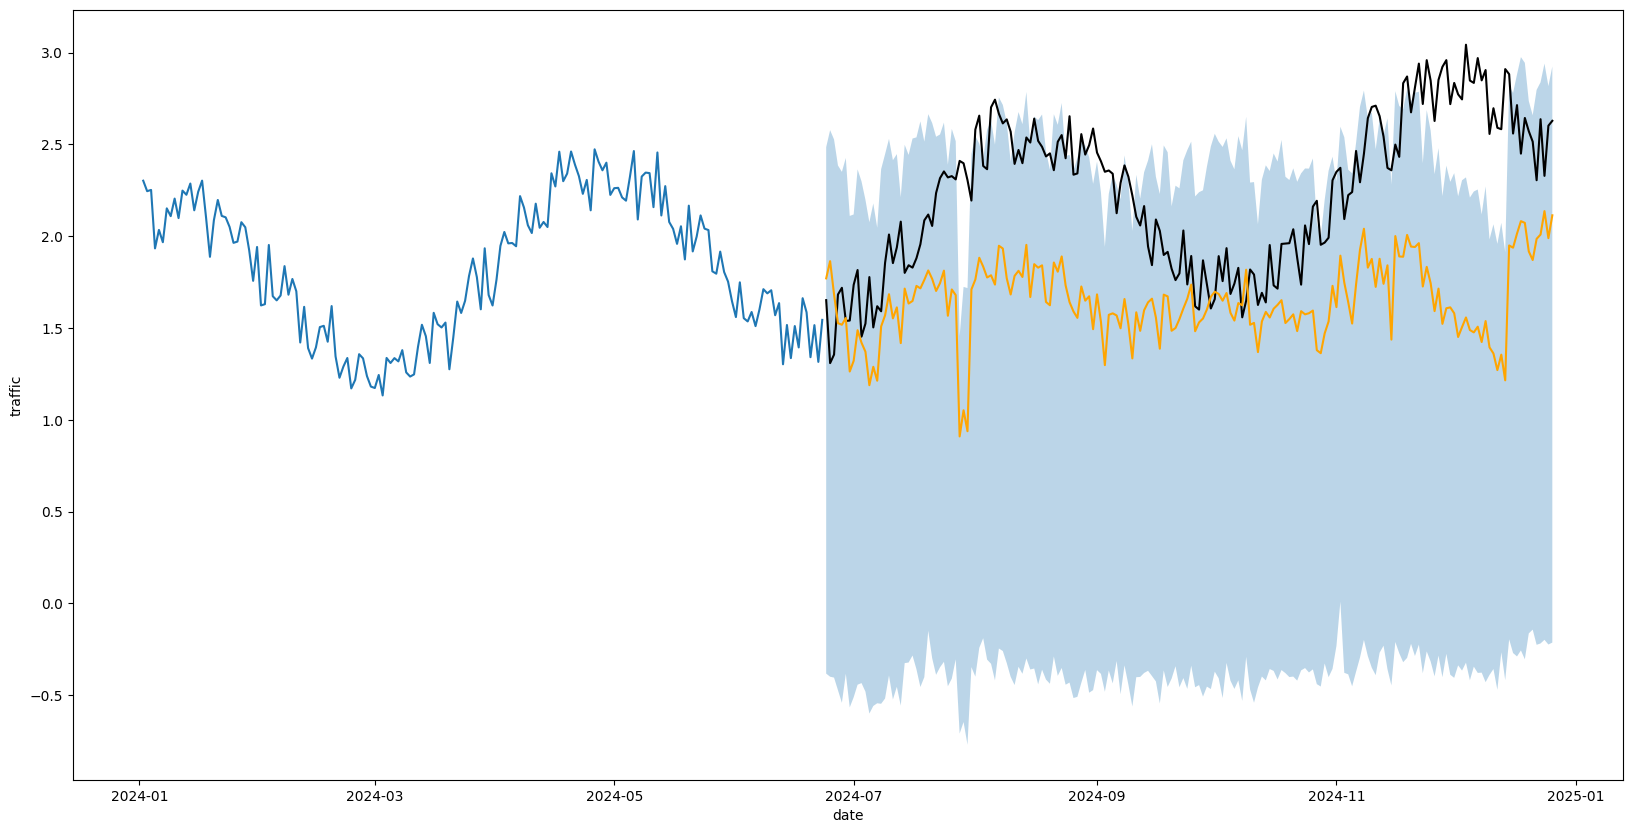

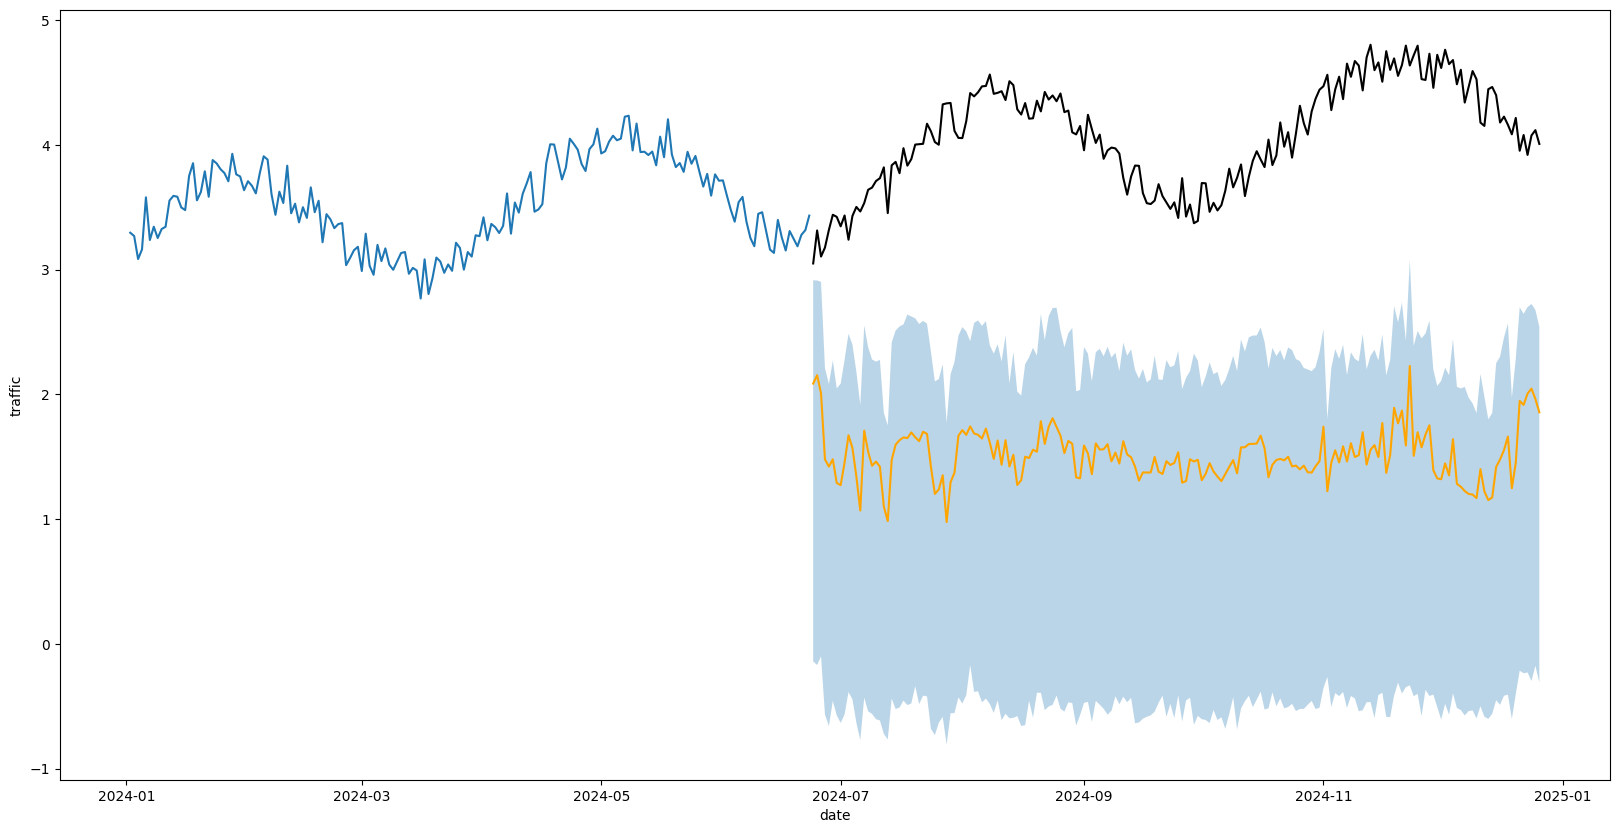

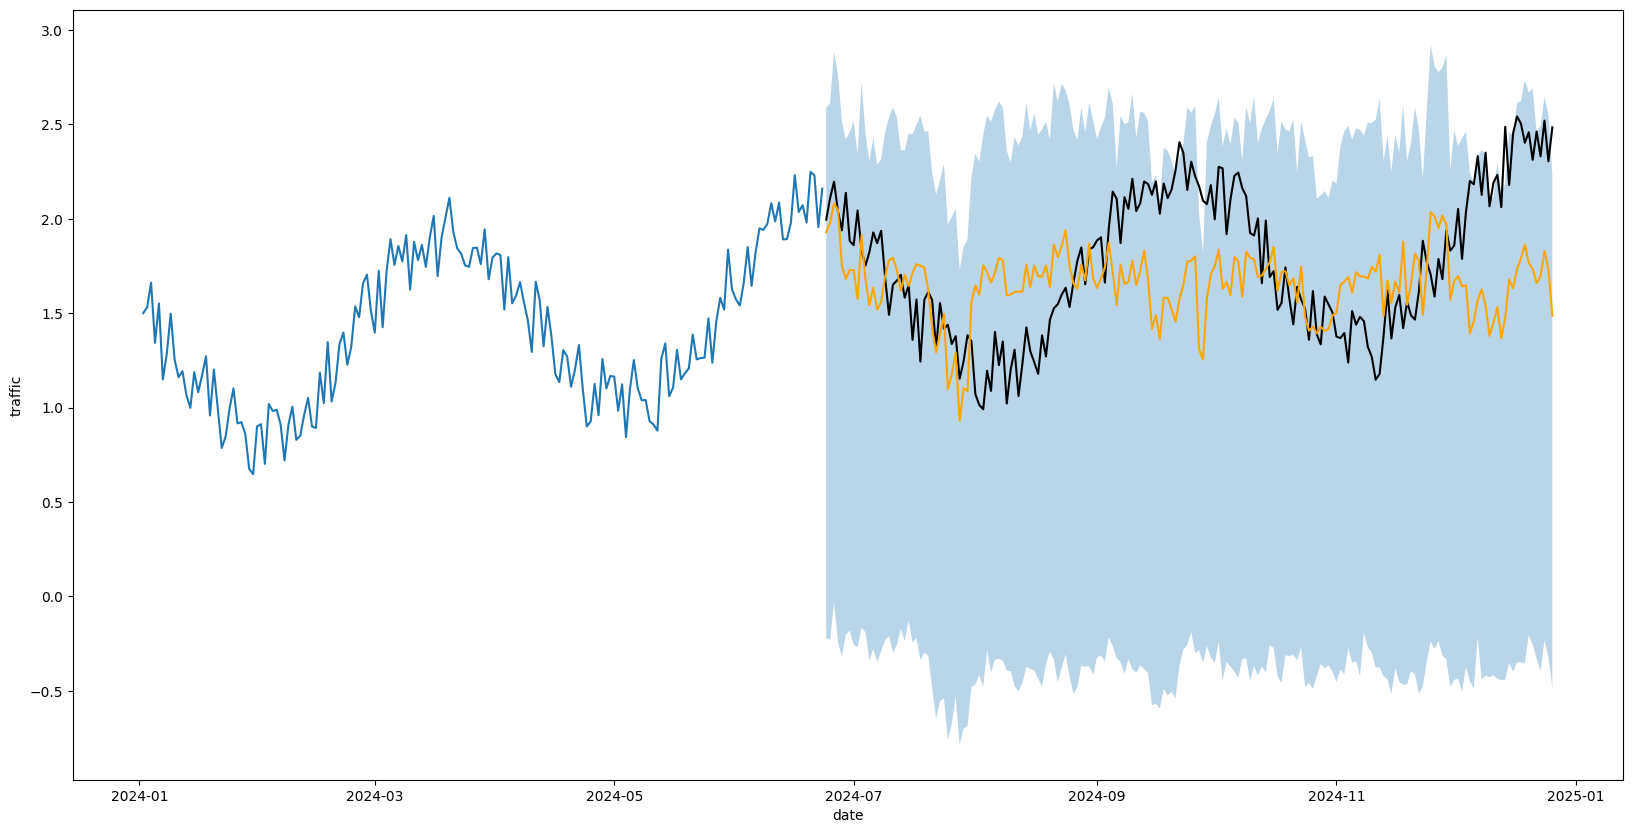

In [18]:
for i in test.Entity.unique():
    plt.figure(figsize=(20,10))
    sns.lineplot(x=test[test["Entity"]==i].iloc[:ENCODER_STEPS-1]["date"], y=test[test["Entity"]==i].iloc[:ENCODER_STEPS-1]["traffic"])
    sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].labels, color="black")
    # sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p10, color="red")
    sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p50, color="orange")
    # sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p90, color="green")

    plt.fill_between(out_df[out_df["identifier"]==i].index, out_df[out_df["identifier"]==i].p10, out_df[out_df["identifier"]==i].p90, alpha=0.3)

    plt.show()